# Daniel Brun - Final Project

### <font color='red'>NOTE - PLEASE READ CAREFULLY BEFORE RUNNING THIS PROJECT</font>

### Hardware Requirements:
#### <font color ='darkgreen'>NVIDIA GPU's with CUDA</font> 
#### Minimum 32GB to 64GB of RAM
#### Hexa or Octacore processor

-------------------------------------------------------------------------------------------------------------------------

### Software Requirements Outside Anaconda:
#### CUDA Toolkit: https://developer.nvidia.com/cuda-toolkit
#### Microsoft Visual Studio 2019: https://visualstudio.microsoft.com/
#### Java: https://www.java.com/

-------------------------------------------------------------------------------------------------------------------------

### Software Requirements in Anaconda:
#### Conda Environment: Python 3.7.x
#### CUDA toolkit: conda install -c numba cudatoolkit
#### Numba: conda install -c numba numba
#### ImageJ: conda install -c conda-forge pyimagej
#### GPUtil: pip install GPUtil
#### Pillow: pip install Pillow
#### PyDMD: pip install pydmd

-------------------------------------------------------------------------------------------------------------------------

### Code Settings for Run:
#### User: Select '0' only if developer
#### Numba or ImageJ: Select 0 if using PIL or 1 if using ImageJ to import images
#### CPU or GPU: Type 'CPU' if you prefer running all in the CPU or 'GPU' if you want to take advantage of NVIDIA
#### Benchmark: Type '1' if you want to test performance of your CPU vs your GPU
#### Test Real CPU: Type '1' if you want to do everything in serial with one core
#### Throttle: Select images with different steps in case filtering is needed

In [1]:
# Type 1 if you downloaded the files. Zero only works for code creator

user = 0                                        # 0 only for developer
numba_or_imagej_image = 1                       # PIL 1, ImageJ 0
CPU_or_GPU = 'GPU'                              # Using NVIDIA GPU? Answer with 'CPU' if you don't or 'GPU'
clean_ram_when_done = 1                         # Erase RAW images imported when done processing images? 0 no, 1 yes
benchmark = 1                                   # Benchmark to compare CPU vs GPU: 0 no, 1 yes
test_real_cpu = 0                               # If you want to compare 1 to 1 CPU vs GPU (Long time, vast ram consumed)
throttle_value = 25                             # For memory and optimization, if frames can be removed improves ram
bench_img_quantity = 100                         # Images per case to be benchmarked

### Package Import

In [2]:
# Ignore warnings. Only use if you are sure your packages work. This prevent red messages that might be confusing.
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

# Import Packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import pyplot as plt
import pandas as pd                             # Not used

# Extra Packages
import imagej
import numba as nb
import GPUtil
from numba import cuda
from numba import jit, njit, float32, vectorize, uint32, f8, uint8, float64
import glob
import os
import time
from timeit import default_timer as timer
from PIL import Image, ImageEnhance
import sys
import time
import timeit
defTime = lambda: timeit.default_timer()
import math
import gc
from IPython.display import HTML, display, Markdown,Latex
from pydmd import DMD
from termcolor import colored
import psutil
import platform
from datetime import datetime

### CPU and GPU function for detailed data

In [4]:
def get_os():
    global os_being_used
    os_used = platform.system()
    release_used = platform.release()
    return os_used + ' ' + release_used

In [5]:
def get_cpu_type():
    from win32com.client import GetObject
    root_winmgmts = GetObject("winmgmts:root\cimv2")
    cpus = root_winmgmts.ExecQuery("Select * from Win32_Processor")
    return cpus[0].Name

In [6]:
def get_gpu_type():
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        gpu_name = gpu.name
        return gpu_name

In [7]:
def get_ram_usage():
    global ram_usage
    svmem = psutil.virtual_memory()
    ram_usage = get_size(svmem.used)

In [8]:
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

In [9]:
# Check if you have NVDIA GPU's with CUDA cores available
cuda.detect()

# Initialize imagej

if numba_or_imagej_image == 0:
    ij = imagej.init()
    print('ImageJ Initialized')

Found 1 CUDA devices
id 0     b'GeForce RTX 3070'                              [SUPPORTED]
                      compute capability: 8.6
                           pci device id: 0
                              pci bus id: 1
Summary:
	1/1 devices are supported


# Pre-Requisits

### Create list of files that are being processed as well as needed variables for post-processing

In [10]:
complete_start_time = timer()
os_running = get_os()
# Define file location and list images

if user == 0:
    download_data_place = r'G:\Research Files\NASA Drone Rover\Schlieren Data'
elif user == 1:
    dowload_data_place = os.getcwd()
    
main_folders = sorted(glob.glob(download_data_place+'\*'))
background_folders = [[[]] * 3]

i = 0
for x in main_folders:
    loc_main = sorted(glob.glob(main_folders[i]+'\*'))
    j = 0
    for y in loc_main:
        if i == 0:
            exp_list_2 = [None] * len(loc_main)
            exp_2 = loc_main
            exp_backg_2 = [None] * len(loc_main)
            k = 0

            for z in exp_2:
                exp_list_2[k] = sorted(glob.glob(exp_2[k]+'\*.tif'))
                k += 1

        elif i == 1:
            exp_list_1 = [None] * len(loc_main)
            exp_1 = loc_main
            k = 0
            
            for z in exp_1:
                exp_list_1[k] = sorted(glob.glob(exp_1[k]+'\*.jpg'))
                k += 1

        elif i == 2:
            exp_list_3 = [None] * len(loc_main)
            exp_3 = loc_main
            exp_backg_3 = [None] * len(loc_main)
            k = 0

            for z in exp_3:
                exp_list_3[k] = sorted(glob.glob(exp_3[k]+'\*.tif'))
                k += 1

        elif i == 3:
            exp_list_4 = [None] * len(loc_main)
            exp_4 = loc_main
            exp_backg_4 = [None] * len(loc_main)
            k = 0

            for z in exp_4:
                exp_list_4[k] = sorted(glob.glob(exp_4[k]+'\*.tif'))
                k += 1
    i += 1

    
exp1 = sorted(exp_list_1)

exp2 = [exp_list_2[0],exp_list_2[2],exp_list_2[3],
        exp_list_2[4],exp_list_2[7],exp_list_2[8],
        exp_list_2[5],exp_list_2[9],exp_list_2[11]]

exp3 = [exp_list_3[1],exp_list_3[2]]
exp4 = [exp_list_4[1],exp_list_4[3],exp_list_4[5],exp_list_4[6],exp_list_4[8]]


exp2_bg = [exp_list_2[1],exp_list_2[1],exp_list_2[1],
           exp_list_2[1],exp_list_2[12],exp_list_2[12],
           exp_list_2[6],exp_list_2[10],exp_list_2[10]]

exp3_bg = [exp_list_3[0],exp_list_3[0]]
exp4_bg = [exp_list_4[0],exp_list_4[2],exp_list_4[4],exp_list_4[7],exp_list_4[7]]
    
whole_list = [exp1,exp2,exp3,exp4]
bg_list = [exp2_bg,exp3_bg,exp4_bg]

x = len(whole_list)
y = [len(exp1),len(exp2),len(exp3),len(exp4)]

conv_files_pil = [[[]]for i in range(x)]
conv_files = [[[]]for i in range(x)]
conv_files_bg = [[[]]for i in range(x)]
conv_avg_bg = [[[]]for i in range(x)]

mult_files = [[[]]for i in range(x-1)]
dmd_list = [[]for i in range(x-1)]
mult_files_cpu = [[[]]for i in range(x-1)]

i = 0
ii = 0

for xx in range(x):
    conv_files[ii] = [[] for i in range(y[i])]
    i += 1
    ii += 1
    
i = 0
ii = 0

for xx in range(x):
    conv_files_pil[ii] = [[] for i in range(y[i])]
    i += 1
    ii += 1

i = 0
ii = 0    
    
for xx in range(x-1):
    mult_files[ii] = [[] for i in range(y[i+1])]
    mult_files_cpu[ii] = [[] for i in range(y[i+1])]
    i += 1
    ii += 1

norm_files_total = mult_files
norm_files_total_cpu = mult_files_cpu
    
x = len(bg_list)
y = [len(exp2_bg),len(exp3_bg),len(exp4_bg)]

i = 0
ii = 0

for xx in range(x):
    conv_files_bg[ii] = [[]for i in range(y[i])]
    conv_avg_bg[ii] = [[]for i in range(y[i])]
    i += 1
    ii += 1
    
# List to clean from ram

list_to_clean = [exp1, exp2, exp3, exp4, exp2_bg, exp3_bg, exp4_bg, whole_list, bg_list]

## Functions for Post-Processing and Image Cleaning

### Background Images Import Function

In [11]:
# Import Background

def import_images_numba_pil_bg(i,j,z):
    
    img = Image.open(z).convert('L')
    np_img = np.array(img)
    np_img = np.array(np_img, dtype = 'float16')
    conv_files_bg[i][j].append(np_img)

def import_background_and_avg():
    global conv_avg_bg
    global conv_files_bg
    i = 0
    startt = timer()
    img_processed = 0
    for x in bg_list:
        j = 0
        for y in x:
            k = 0
            bg_sumation_avg = 0
            for z in y:
                import_images_numba_pil_bg(i,j,z)
                image_collection = conv_files_bg[i][j][k]
                bg_sumation_avg += image_collection
                print('Background Average Calculation | Experiment %0.0f Case %0.0f | Image: %0.0f'%(i+1,j+1,k),end = '\r')
                k += 1
                img_processed += 1
            result_avg = bg_sumation_avg/k
            result_avg = np.array(result_avg, dtype = 'float16')
            conv_avg_bg[i][j].append(result_avg)
            j += 1
        i += 1
    del conv_files_bg
    gc.collect()
    
    dt = timer() - startt
    avg_img_time = dt/img_processed
    print('Total Images %0.0f | Total Processing Time: %0.1f seconds | Average Image Processing Time: %0.5f seconds                                        '%(img_processed,dt,avg_img_time))

### Function ImageJ to Load Images

In [12]:
# Use ImageJ to process images
def image_j_process(i,j,z):
    image_op = ij.io().open(z)
    conv_files[i][j].append(ij.py.from_java(image_op))
    

### Function PIL to Load Images

In [13]:
# Use PIL for import images
def import_images_numba_pil(i,j,z):
    img = Image.open(z).convert('L')
    np_img = np.array(img)
    np_img = np.array(np_img, dtype = 'float16')
    conv_files_pil[i][j].append(np_img)

### Function for Image Conversion to Array

In [14]:
# Extraction process function
def extraction_process():
    bench_img = bench_img_quantity - 1
    start = timer()
    imag_quantity = 0
    i = 0
    for x in whole_list:
        j = 0
        for y in x:
            startTime = defTime()
            drawTimes = []
            totalFiles = float(len(y))
            
            k = 0
            image_number = 0
            
            if benchmark == 0:
                
                for z in y:
                    drawStartTime = defTime()

                    z = y[k]
                    if numba_or_imagej_image == 0:
                        image_j_process(i,j,z)
                        k += throttle_value
                        image_number += 1
                        imag_quantity += 1

                    elif numba_or_imagej_image == 1:
                        import_images_numba_pil(i,j,z)
                        k += throttle_value
                        image_number += 1
                        imag_quantity += 1

                    if i == 0:
                        format_img = 'jpeg '
                    elif i > 0:
                        format_img = 'tif '

                    drawEndTime = defTime()
                    drawTime = drawEndTime - drawStartTime
                    drawTimes.append(drawTime)
                    elapsedTime = defTime() - startTime
                    totalTime = totalFiles * np.mean(drawTimes)
                    remainingTime = totalFiles * np.mean(drawTimes) - elapsedTime
                    drawTimes.append(drawTime)

                    print('Working with: Experiment %0.0f Case %0.0f | Image: %0.0f | Time per frame: %0.3fs | Remaining Time: %0.3fs | Total Time: %0.3fs                          '%(i+1, j+1, image_number+1, drawTime, remainingTime, totalTime), end = '\r')

                    
            elif benchmark == 1:
            
                while image_number <= bench_img:
                    drawStartTime = defTime()

                    z = y[k]
                    if numba_or_imagej_image == 0:
                        image_j_process(i,j,z)
                        k += throttle_value
                        image_number += 1
                        imag_quantity += 1

                    elif numba_or_imagej_image == 1:
                        import_images_numba_pil(i,j,z)
                        k += throttle_value
                        image_number += 1
                        imag_quantity += 1

                    if i == 0:
                        format_img = 'jpeg '
                    elif i > 0:
                        format_img = 'tif '

                    drawEndTime = defTime()
                    drawTime = drawEndTime - drawStartTime
                    drawTimes.append(drawTime)
                    elapsedTime = defTime() - startTime
                    totalTime = totalFiles * np.mean(drawTimes)
                    remainingTime = totalFiles * np.mean(drawTimes) - elapsedTime
                    drawTimes.append(drawTime)

                    print('Working with: Experiment %0.0f Case %0.0f | Image: %0.0f | Time per frame: %0.3fs | Remaining Time: %0.3fs | Total Time: %0.3fs                          '%(i+1, j+1, image_number+1, drawTime, remainingTime, totalTime), end = '\r')

            j += 1
        i += 1

    dt = timer() - start
    avg_img_time = dt/imag_quantity
    print('Total Images %0.0f | Total Processing Time: %0.1f seconds | Average Image Processing Time: %0.5f seconds                                                                                            '%(imag_quantity,dt,avg_img_time))

### Functions for Background Division using NVIDIA GPU

In [15]:
@cuda.jit
def divide_background_gpu(a, b, c): 
    s1, s2 = cuda.grid(2)
    d1, d2 = cuda.gridsize(2)
    for i1 in range(s1, a.shape[0], d1): 
        for i2 in range(s2, b.shape[0], d2): 
            the_sum = (a[i1][i2] + 25) / (b[i1][i2] + 25)
            c[i1, i2] = the_sum

In [16]:
@cuda.jit
def normalize_background_gpu(a, normalize, c): 
    s1, s2 = cuda.grid(2)
    d1, d2 = cuda.gridsize(2)
    for i1 in range(s1, c.shape[0], d1): 
        for i2 in range(s2, c.shape[1], d2): 
            the_sum = 255 * a[i1][i2] / normalize
            c[i1, i2] = the_sum

In [17]:
def use_gpu_process():
    global mult_files
    global gpu_time_image
    
    global gpu_time_per_img 
    global gpu_total_img_time
    global gpu_time
    
    gpu_time_per_img = []
    
    timetot = 0
    GPU = get_gpu_type()
    whole_start = timer()
    size_need = conv_files_pil[1][0][0]
    data_size = size_need
    threadsperblock = (32,32)
    blockspergrid_x = math.ceil(data_size.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(data_size.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    total_files = 0
    
    x = 0
    
    for i in range(1,4):
        xxx = conv_files_pil[i]
        
        j = 0
        i_bg = i-1
        for xx in xxx:
            jj = 0
            y = conv_avg_bg[i_bg][j][0]
            
            for x in xx: 
                a = x
                a = np.array(a, dtype = 'float32')
                b = y
                b = np.array(y, dtype = 'float32')
                d_a = cuda.to_device(a)
                d_b = cuda.to_device(b)
                c = np.zeros((a.shape[0], b.shape[1]))
                d_c = cuda.to_device(c)
                start = timer()
                divide_background_gpu[blockspergrid,threadsperblock](d_a, d_b, d_c)
                print('Experiment %0.0f | Case %0.0f | Frame % 0.0f | Background Substraction'%(i,j+1,jj+1), end = '\r')
                dt = timer() - start
                timetot = timetot + dt
                gpu_time_per_img.append(dt)
                pp_c = d_c.copy_to_host()
                pp_c = np.array(pp_c, dtype = 'float16')
                mult_files[i_bg][j].append(pp_c)
                
                total_files += 1
                jj += 1
            
            j +=1
    
    totalTime_of_process = timer() - whole_start
    gpu_time_image = totalTime_of_process
    avg_img_time = timetot/total_files
    
    gpu_total_img_time = timetot
    gpu_time = totalTime_of_process
    
    print('                                                                                                                                                            ')
    print(GPU + ': \n\u2022 Images Processed %0.0f \n\u2022 Image Processing Time: %0.5f seconds \n\u2022 Average Image Processing Time: %0.5f seconds \n\u2022 Total Process Time: %0.5f seconds'%(total_files, timetot, avg_img_time, totalTime_of_process))
    test_1 = d_c.copy_to_host()
    #plt.imshow(test_1, cmap = 'gray')

In [18]:
def use_gpu_normalize():
    global norm_files_total
    startt = timer()
    size_need = mult_files[1][0][0]
    data_size = size_need
    threadsperblock = (32,32)
    blockspergrid_x = math.ceil(data_size.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(data_size.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    img_processed = 0
    for i in range(1,4):
        xxx = conv_files_pil[i]
        j = 0
        for xx in xxx:
            jj = 0
            mf_array = mult_files[i-1][j]
            norm_array = np.array(mf_array, dtype = 'float32')
            norm_value = norm_array.max()

            for x in xx:
                a = mult_files[i-1][j][jj]
                a = np.array(a, dtype = 'float32')
                d_a = cuda.to_device(a)
                c = np.zeros((a.shape[0], a.shape[1]))
                d_c = cuda.to_device(c)
                normalize_background_gpu[blockspergrid,threadsperblock](d_a, norm_value, d_c)
                print('Experiment %0.0f | Case %0.0f | Frame % 0.0f | Normalization'%(i,j+1,jj+1), end = '\r')
                pp_c = d_c.copy_to_host()
                norm_files_total[i-1][j].append(pp_c)
                
                jj += 1
                img_processed += 1
            del norm_array
            gc.collect()
            j +=1
    time_proc = timer() - startt
    print('Normalized Images: %0.0f | Total Time: %0.1f seconds                               '%(img_processed,time_proc))

### Functions for Background Division using CPU

In [19]:
@jit
def divide_background_cpu(a, b, c): 
    for i1 in range(a.shape[0]): 
        for i2 in range(a.shape[1]):
            try:
                the_sum = (a[i1][i2] + 25) / (b[i1][i2] + 25)
            except ZeroDivisionError:
                the_sum = 0
                c[i1, i2] = the_sum

In [20]:
def use_cpu_process():
    global mult_files_cpu
    global cpu_one_to_one_time
    
    global cpu_time_per_img 
    global cpu_total_img_time
    global cpu_time
    
    cpu_time_per_img = []
    
    timetot = 0
    CPU = get_cpu_type()
    whole_start = timer()
    total_files = 0
    
    for i in range(1,4):
        xxx = conv_files_pil[i]

        j = 0
        i_bg = i-1
        for xx in xxx:
            jj = 0
            y = conv_avg_bg[i_bg][j][0]
            for x in xx:
                
                b = np.array(y, dtype = 'float32')
                a = np.array(x, dtype = 'float32')
                c = np.zeros((a.shape[0], b.shape[1]))
                start = timer()
                divide_background_cpu(a,b,c)
                print('Experiment %0.0f | Case %0.0f | Frame % 0.0f | Background Substraction'%(i,j+1,jj+1), end = '\r')
                dt = timer() - start
                cpu_time_per_img.append(dt)
                timetot = timetot + dt
                pp_c = np.array(c, dtype = 'float16')
                mult_files_cpu[i_bg][j].append(pp_c)
                total_files += 1
                jj += 1
                
            j += 1
    totalTime_of_process = timer() - whole_start
    cpu_one_to_one_time = totalTime_of_process
    avg_img_time = timetot/total_files
    
    cpu_total_img_time = timetot
    cpu_time = totalTime_of_process
    
    print('                                                                                                                                                            ')
    print(CPU + ': \n\u2022 Images Processed %0.0f \n\u2022 Image Processing Time: %0.5f \n\u2022 Average Image Processing Time: %0.5f seconds \n\u2022 Total Process Time: %0.5f seconds'%(total_files, timetot, avg_img_time, totalTime_of_process))
    test_1 = c
    #plt.imshow(test_1, cmap = 'gray')

In [21]:
def use_cpu_normalize():
    global norm_files_total_cpu
    
    for i in range(1,4):
        xxx = conv_files_pil[i]
        j = 0
        for xx in xxx:
            jj = 0
            mf_array = mult_files[i-1][j]
            norm_array = np.array(mf_array, dtype = 'float32')
            norm_value = norm_array.max()
            del norm_array
            gc.collect()
            for x in xx: 
                a = np.reshape(mult_files[i-1][j][jj],(1024,1024))
                c = np.zeros((a.shape[0], a.shape[1]))
                pp_c = 255 * a/norm_value
                pp_c = pp_c.flatten()
                print('Experiment %0.0f | Case %0.0f | Frame % 0.0f | Normalization'%(i,j,jj), end = '\r')
                norm_files_total_cpu[i-1][j].append(pp_c)
                
                jj += 1
            
            j +=1

In [22]:
def use_cpu_process_complete_division():
    global mult_files_cpu
    global cpu_one_short_time
    timetot = 0
    whole_start = timer()
    CPU = get_cpu_type()
    total_files = 0
    
    x = 0
    
    for i in range(1,4):
        xxx = conv_files_pil[i]
        j = 0
        i_bg = i-1
        
        for xx in xxx:
            jj = 0
            y = conv_avg_bg[i_bg][j][0]
            for x in xx:
                b = np.array(y, dtype = 'float32')
                a = np.array(x, dtype = 'float32')
                c = np.zeros((a.shape[0], b.shape[1]))
                start = timer()
                the_sum = a / b
                c = the_sum
                pp_c = np.array(c, dtype = 'float16')
                print('Experiment %0.0f | Case %0.0f | Frame % 0.0f | Background Substraction'%(i,j,jj), end = '\r')
                dt = timer() - start
                timetot = timetot + dt
                mult_files_cpu[i_bg][j].append(pp_c)
                total_files += 1
                jj += 1
                    
            j += 1
            
    totalTime_of_process = timer() - whole_start
    cpu_one_short_time = totalTime_of_process
    
    print('                                                                                                                                                            ')
    print(CPU + ': \n\u2022 Images Processed %0.0f \n\u2022 Image Processing Time: %0.5f seconds \n\u2022 Average Image Processing Time: %0.5f seconds \n\u2022 Total Process Time: %0.5f seconds'%(total_files, timetot, totalTime_of_process), end = '\n')
    test_1 = c
    #plt.imshow(test_1, cmap = 'gray')

### Benchmark Results

In [23]:
def benchmark_results():
    print(colored('\nBenchmark Results:',attrs = ['bold','underline']))
    CPU = get_cpu_type()
    GPU = get_gpu_type()
    
    labels = ['Total Time for Images','Total Time']
    
    score_gpu = [gpu_total_img_time,gpu_time]
    score_cpu = [cpu_total_img_time,cpu_time]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, score_cpu, width, label=CPU, color = 'mediumblue')
    rects2 = ax.bar(x + width/2, score_gpu, width, label=GPU, color = 'limegreen')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Seconds')
    ax.set_title('Benchmark Scores of: %s vs %s'%(CPU,GPU), y = 1.05)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0,30)
    ax.legend(loc = 'upper left')

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()


In [24]:
def benchmark_time_results():
    global os_running
    print(colored('\nBenchmark Time Results:',attrs = ['bold','underline']))
    CPU = get_cpu_type()
    GPU = get_gpu_type()
    x1 = cpu_time_per_img[1:]
    x2 = gpu_time_per_img[1:]
    
    fig, ax = plt.subplots()
    rects1 = ax.plot(x1, label=CPU, color = 'mediumblue')
    rects2 = ax.plot(x2, label=GPU, color = 'limegreen')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Seconds')
    ax.set_title('Benchmark Scores of: %s vs %s'%(CPU,GPU), y = 1.05)
    ax.legend(loc = 'upper left')

    plt.show()
    
    cpu_percentile = np.percentile(cpu_time_per_img[1:],99)
    gpu_percentile = np.percentile(gpu_time_per_img[1:],99)
    
    print('\nOperating System: '+os_running)
    print('\n'+CPU + ':')
    print('\u2022 First Load: %0.8f'%float(cpu_time_per_img[0]))
    print('\u2022 99th Percentile: %0.8f'%float(cpu_percentile))
    print('\n'+GPU + ':')
    print('\u2022 First Load: %0.8f'%float(gpu_time_per_img[0]))
    print('\u2022 99th Percentile: %0.8f'%float(gpu_percentile))
    

### Function Dynamic Mode Decomposition

In [25]:
def exp_dmd():
    global dmd_list    
    i = 0
    for x in norm_files_total:
        j = 0
        for y in range(len(x)):  
            print('Creating DMD Instance for: Experiment %0.0f | Case %0.0f'%(i+1,j+1), end = '\r')
            schlieren_to_process = norm_files_total[i][j]
            dmd = DMD(svd_rank = 0, rescale_mode = 'auto')
            dmd_creation = dmd.fit(schlieren_to_process)
            dmd_list[i].append(dmd_creation)
            j += 1
        i += 1
    print('DMD Instance Generated for All Experiment and Cases                     ')

In [26]:
def create_gifs_original():
    global x_lim_top
    global y_lim_top
    global x_lim_bot
    global y_lim_bot
    i = 0
    for x in range(1,4):
        xx = conv_files_pil[x]
        j = 0
        for y in xx:
            if x == 1:
                x_lim_top = [380, 380, 380, 380, 0, 0, 380, 380, 380]
                x_lim_bot = [910, 910, 910, 910, 1024, 1024, 910, 910, 910]
                y_lim_top = [250, 250, 250, 250, 0, 0, 250, 250, 250]
                y_lim_bot = [780, 780, 780, 780, 1024, 1024, 780, 780, 780]

            elif x == 2:
                x_lim_top = [260, 260]
                x_lim_bot = [780, 780]
                y_lim_top = [200, 200]
                y_lim_bot = [720, 720]

            elif x == 3:
                x_lim_top = [350, 350, 350, 350, 350]
                x_lim_bot = [900, 900, 900, 900, 900]
                y_lim_top = [250, 250, 250, 250, 250]
                y_lim_bot = [800, 800, 800, 800, 800]
                
            k = 0
            empty_frames = []
            for z in y:
                im = conv_files_pil[x][j][k]
                im = np.array(im, dtype = 'float32')
                frame = Image.fromarray(im)
                frame = frame.convert('L')
                new_frame = frame.crop((x_lim_top[j],y_lim_top[j],x_lim_bot[j],y_lim_bot[j]))
                enhancer = ImageEnhance.Contrast(new_frame)
                new_frame = enhancer.enhance(2.0)
                empty_frames.append(new_frame)
                k += 1
            case_name = r'Original/Exp %0.0f Case %0.0f Original.gif'%(i+1,j+1)
            empty_frames[0].save(case_name, format = 'GIF', append_images = empty_frames[1:], save_all = True, duration = 5, loop = 0)
            del empty_frames
            gc.collect()
            j += 1
        i += 1

In [27]:
def create_gifs_post_process():
    i = 0
    for x in range(1,4):
        xx = conv_files_pil[x]
        j = 0
        for y in xx:
            if x == 1:
                x_lim_top = [380, 380, 380, 380, 0, 0, 380, 380, 380]
                x_lim_bot = [910, 910, 910, 910, 1024, 1024, 910, 910, 910]
                y_lim_top = [250, 250, 250, 250, 0, 0, 250, 250, 250]
                y_lim_bot = [780, 780, 780, 780, 1024, 1024, 780, 780, 780]

            elif i == 1:
                x_lim_top = [260, 260]
                x_lim_bot = [780, 780]
                y_lim_top = [200, 200]
                y_lim_bot = [720, 720]

            elif x == 3:
                x_lim_top = [350, 350, 350, 350, 350]
                x_lim_bot = [900, 900, 900, 900, 900]
                y_lim_top = [250, 250, 250, 250, 250]
                y_lim_bot = [800, 800, 800, 800, 800]
                
            k = 0
            empty_frames = []
            for z in y:
                im = norm_files_total[i][j][k]
                im = np.array(im, dtype = 'float32')
                frame = Image.fromarray((im*255)/2.5)
                frame = frame.convert('L')
                new_frame = frame.crop((x_lim_top[j],y_lim_top[j],x_lim_bot[j],y_lim_bot[j]))
                enhancer = ImageEnhance.Contrast(new_frame)
                new_frame = enhancer.enhance(2.0)
                empty_frames.append(new_frame)
                k += 1
            case_name = r'PostProcessed/Exp %0.0f Case %0.0f PostProcessed.gif'%(i+1,j+1)
            empty_frames[0].save(case_name, format = 'GIF', append_images = empty_frames[1:], save_all = True, duration = 5, loop = 0)
            del empty_frames
            gc.collect()
            j += 1
        i += 1

# Data Process and Plot Functions

### Data Process

In [28]:
def start_data_process():
    try:
        global conv_files_pil, mult_files, mult_files_cpu
        print(colored('Import and Average Backgrounds:',attrs = ['bold','underline']))
        import_background_and_avg()
        print(colored('\nDone!','green'))

        print(colored('\nStart Image Extraction:',attrs = ['bold','underline']))
        extraction_process()
        mid_time_before_process = timer()
        pre_process_timer = mid_time_before_process - complete_start_time
        for x in list_to_clean:
            del x
            gc.collect()
        print(colored('\nDone!','green'))

        print(colored('\nCreate GIFs with Original Images:',attrs = ['bold','underline']))
        create_gifs_original()
        print(colored('\nDone!','green'))
        
        if benchmark == 0:
            if CPU_or_GPU == 'GPU':
                use_gpu_process()
            elif CPU_or_GPU == 'CPU':
                use_cpu_process()

        if benchmark == 1:
            print(colored('\nUse of GPU for Background Substraction:',attrs = ['bold','underline']))
            use_gpu_process()
            final_gpu = gpu_time_image + pre_process_timer
            print('\u2022 Script Processing Time: %0.5f'%final_gpu)
            print(colored('\nDone!','green'))

            print(colored('\nUse of CPU for Background Substraction:',attrs = ['bold','underline']))
            use_cpu_process()        
            final_cpu = cpu_one_to_one_time + pre_process_timer
            print('\u2022 Script Processing Time: %0.5f'%final_cpu)  
            print(colored('\nDone!','green'))
            
            benchmark_results()
            benchmark_time_results()
            
        print(colored('\nUse of GPU for Image Normalization:',attrs = ['bold','underline']))
        use_gpu_normalize()  
        print(colored('\nDone!','green'))
        
        print(colored('\nCreate GIFs with Post-Processed Images:',attrs = ['bold','underline']))
        create_gifs_post_process()
        print(colored('\nDone!','green'))        
        
        print(colored('\nClean RAM',attrs = ['bold','underline']))
        get_ram_usage()
        print('Before cleaning:',ram_usage,end = '')
        if clean_ram_when_done == 1:
            del conv_files_pil
            del mult_files
            del mult_files_cpu
            gc.collect()
        get_ram_usage()
        print(' | After cleaning:',ram_usage)
        print(colored('\nDone!','green'))
        
        # Convert files to Float32 to process
        print(colored('\nTransform Images to float32 and visualization:',attrs = ['bold','underline']))
        timer_convert = timer()
        i = 0
        for x in norm_files_total:
            j = 0
            for y in x:
                k = 0
                for z in range(len(y)):
                    figure_conv = norm_files_total[i][j][k]
                    figure_conv = np.flip(figure_conv)
                    figure_conv = np.fliplr(figure_conv)
                    norm_files_total[i][j][k] = np.array(figure_conv, dtype = 'float32')
                    print('Converted from float16 to float32: Experiment %0.0f | Case %0.0f'%(i+1,j+1), end = '\r')
                    k += 1
                j += 1
            i += 1
        dt = timer() - timer_convert
        print('Float Conversion Total Time: %0.2f seconds                                                          '%dt)
        print(colored('\nDone!','green'))

        print(colored('\nCreate DMD Instances:',attrs = ['bold','underline']))
        exp_dmd()
        print(colored('\nDone!','green'))
        
    except:
        print('                                                              ')
        print(colored('\n Error Found! Check Code','red'))
        sys.exit(1)

### Plot Results

In [29]:
def plot_results():
    try:
        i = 0

        for x in norm_files_total:
            j = 0


            for y in range(len(x)):
                
                if i == 0:
                    x_lim_or = [380, 380, 380, 380, 0, 0, 380, 380, 380]
                    x_lim_end = [910, 910, 910, 910, 1024, 1024, 910, 910, 910]
                    y_lim_or = [250, 250, 250, 250, 0, 0, 250, 250, 250]
                    y_lim_end = [780, 780, 780, 780, 1024, 1024, 780, 780, 780]
                    
                elif i == 1:
                    x_lim_or = [260, 260]
                    x_lim_end = [780, 780]
                    y_lim_or = [310, 310]
                    y_lim_end = [830, 830]
                    
                elif i == 2:
                    x_lim_or = [350, 350, 350, 350, 350]
                    x_lim_end = [900, 900, 900, 900, 900]
                    y_lim_or = [250, 250, 250, 250, 250]
                    y_lim_end = [800, 800, 800, 800, 800]
                
                
                fig, pos = plt.subplots(6,2)
                fig.set_size_inches(15,25)
                fig.tight_layout(pad=0.5, h_pad = 7)

                plt.sca(pos[0,0])
                pp_im = norm_files_total[i][j][0]
                #pp_im = np.flip(pp_im)
                #pp_im = np.fliplr(pp_im)
                pp_image = plt.imshow(pp_im, cmap = 'gray')
                plt.xlim(x_lim_or[j],x_lim_end[j])
                plt.ylim(y_lim_or[j],y_lim_end[j])
                color_b = fig.colorbar(pp_image)
                plt.title('Substracted Background Original: Experiment %0.0f Case %0.0f'%(i+1,j+1), fontsize = 16, y = 1.05)
                                
                plt.sca(pos[0,1])
                dmd_data = dmd_list[i][j]
                flat_recon = dmd_data.reconstructed_data.T
                recon_re = np.reshape(flat_recon[0], (1024,1024))
                recon_re = np.array(recon_re.real, dtype = 'float32')
                #recon_re = np.flip(recon_re)
                #recon_re = np.fliplr(recon_re)
                re_image = plt.imshow(recon_re, cmap = 'gray')
                color_b = fig.colorbar(re_image)
                plt.xlim(x_lim_or[j],x_lim_end[j])
                plt.ylim(y_lim_or[j],y_lim_end[j])
                plt.title('Reconstructed Image: Experiment %0.0f Case %0.0f'%(i+1,j+1), fontsize = 16, y = 1.05)

                plt.sca(pos[1,0])
                dynamic_data = dmd_data.dynamics
                dynamic_plot = plt.plot(dynamic_data.real)
                plt.title('DMD Dynamics: Experiment %0.0f Case %0.0f'%(i+1,j+1), fontsize = 16, y = 1.05)
                plt.ylim(-500,500)

                plt.sca(pos[1,1])
                eigs_test = dmd_data.eigs
                eigenvalues_plot = plt.scatter(eigs_test.real,eigs_test.imag)
                plt.title('DMD Eigenvalues: Experiment %0.0f Case %0.0f'%(i+1,j+1), fontsize = 16, y = 1.05)

                modes_list = [1,3,5,7,10,20,40,45]
                plot_num = range(int(len(modes_list)/2))
                z = 2
                flat_mode = dmd_data.modes.T
                zz = 0
                for mode_number in plot_num:
                    selected_mode = modes_list[zz]
                    plt.sca(pos[z,0])
                    mode_recon = np.reshape(flat_mode[selected_mode ], (1024,1024))
                    mode_recon = np.array(mode_recon.real, dtype = 'float32')
                    #mode_recon = np.flip(mode_recon)
                    #mode_recon = np.fliplr(mode_recon)
                    mode_1_img = plt.imshow(mode_recon, cmap = 'gray')
                    plt.xlim(x_lim_or[j],x_lim_end[j])
                    plt.ylim(y_lim_or[j],y_lim_end[j])
                    color_b = fig.colorbar(mode_1_img)
                    plt.title('DMD Mode %0.0f: Experiment %0.0f Case %0.0f'%(selected_mode,i+1,j+1), fontsize = 16, y = 1.05)

                    selected_mode = modes_list[zz+1]
                    plt.sca(pos[z,1])
                    mode_recon = np.reshape(flat_mode[selected_mode+1], (1024,1024))
                    mode_recon = np.array(mode_recon.real, dtype = 'float32')
                    #mode_recon = np.flip(mode_recon)
                    #mode_recon = np.fliplr(mode_recon)
                    mode_2_img = plt.imshow(mode_recon, cmap = 'gray')
                    plt.xlim(x_lim_or[j],x_lim_end[j])
                    plt.ylim(y_lim_or[j],y_lim_end[j])
                    color_b = fig.colorbar(mode_2_img)
                    plt.title('DMD Mode %0.0f: Experiment %0.0f Case %0.0f'%(selected_mode,i+1,j+1), fontsize = 16, y = 1.05)

                    z += 1
                    zz += 2
                display(Markdown('<font size = "5"><center>Experiment %0.0f Case %0.0f</center></font>'%(i+1,j+1)))
                display(Markdown('----------------------------------------------------------------------------------------------------------------'))
                plt.show()
                j += 1
            i += 1

    except:
        print('                                                              ')
        print(colored('\n Error Found! Check Code','red'))
        sys.exit(1)

## Run!

Import and Average Backgrounds:
Total Images 1440 | Total Processing Time: 27.5 seconds | Average Image Processing Time: 0.01913 seconds                                        

Done!

Start Image Extraction:
Total Images 2000 | Total Processing Time: 59.2 seconds | Average Image Processing Time: 0.02962 seconds                                                                                            

Done!

Create GIFs with Original Images:

Done!

Use of GPU for Background Substraction:
                                                                                                                                                            
GeForce RTX 3070: 
• Images Processed 1600 
• Image Processing Time: 0.56343 seconds 
• Average Image Processing Time: 0.00035 seconds 
• Total Process Time: 22.10843 seconds
• Script Processing Time: 116.37982

Done!

Use of CPU for Background Substraction:
                                                                                        

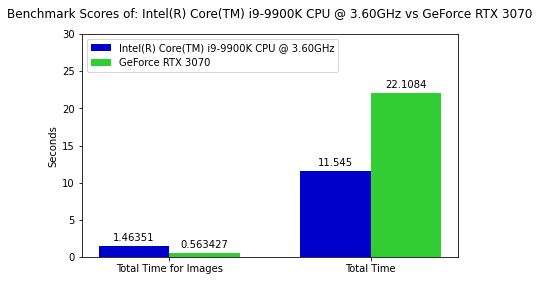


Benchmark Time Results:


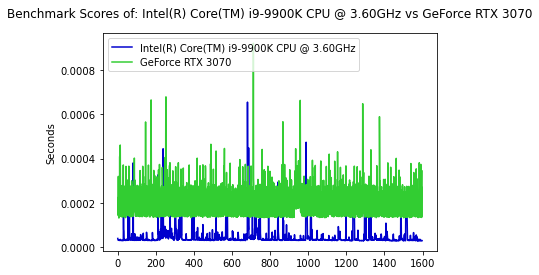


Operating System: Windows 10

Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz:
• First Load: 1.38850680
• 99th Percentile: 0.00022872

GeForce RTX 3070:
• First Load: 0.24919860
• 99th Percentile: 0.00044043

Use of GPU for Image Normalization:
Normalized Images: 1600 | Total Time: 16.3 seconds                               

Done!

Create GIFs with Post-Processed Images:

Done!

Clean RAM
Before cleaning: 28.69GB | After cleaning: 24.78GB

Done!

Transform Images to float32 and visualization:
Float Conversion Total Time: 5.35 seconds                                                          

Done!

Create DMD Instances:
DMD Instance Generated for All Experiment and Cases                     

Done!


<font size = "5"><center>Experiment 1 Case 1</center></font>

----------------------------------------------------------------------------------------------------------------

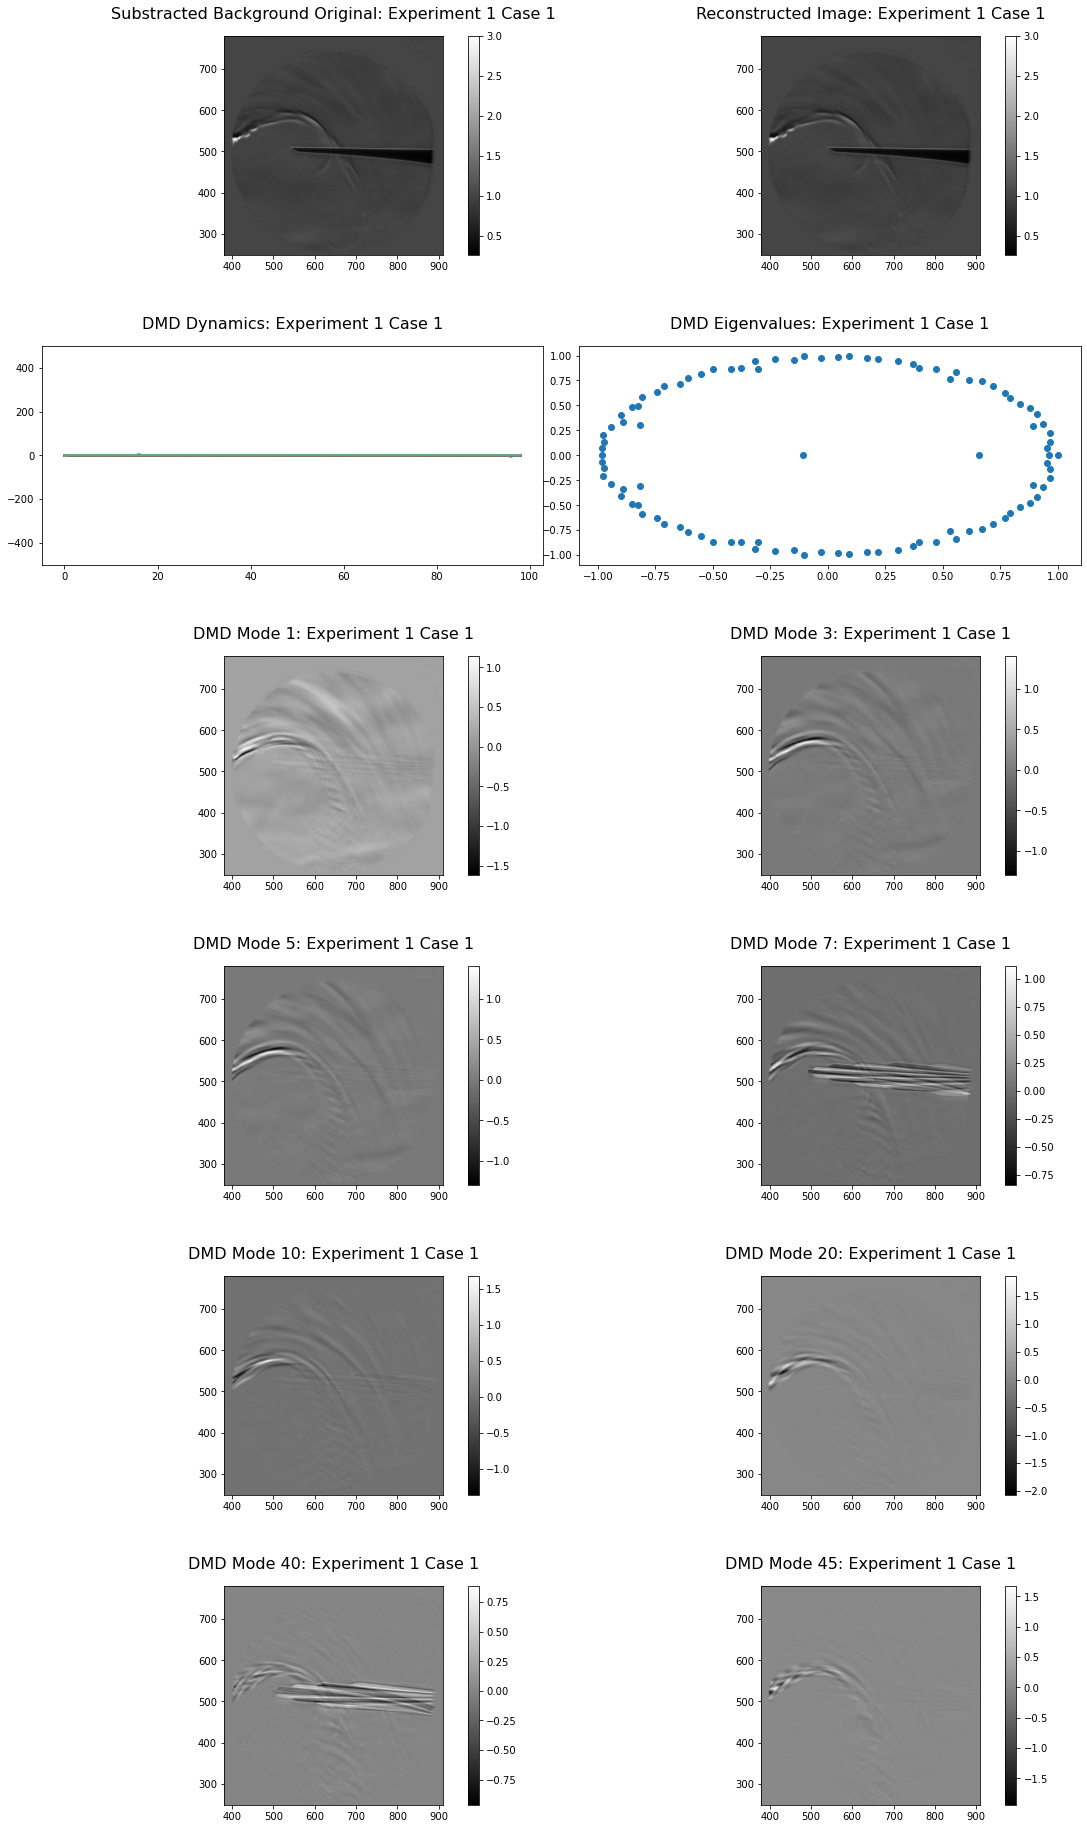

<font size = "5"><center>Experiment 1 Case 2</center></font>

----------------------------------------------------------------------------------------------------------------

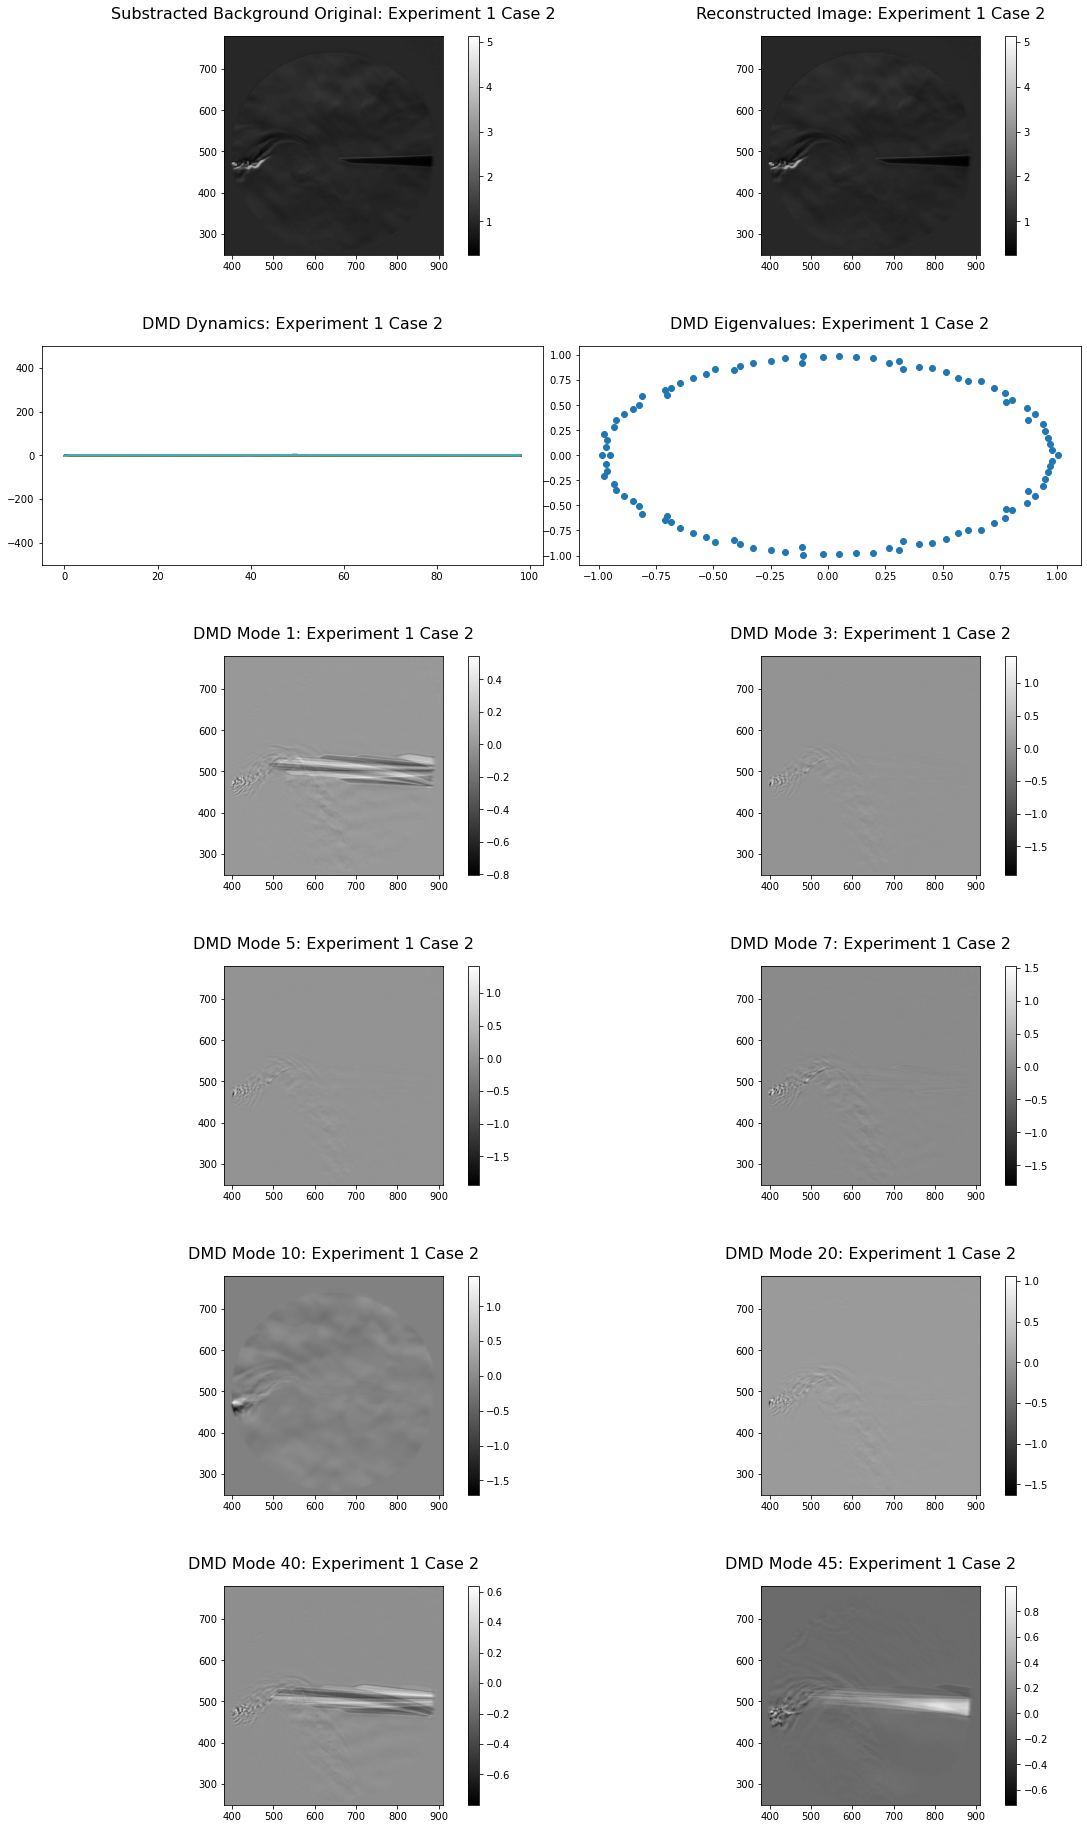

<font size = "5"><center>Experiment 1 Case 3</center></font>

----------------------------------------------------------------------------------------------------------------

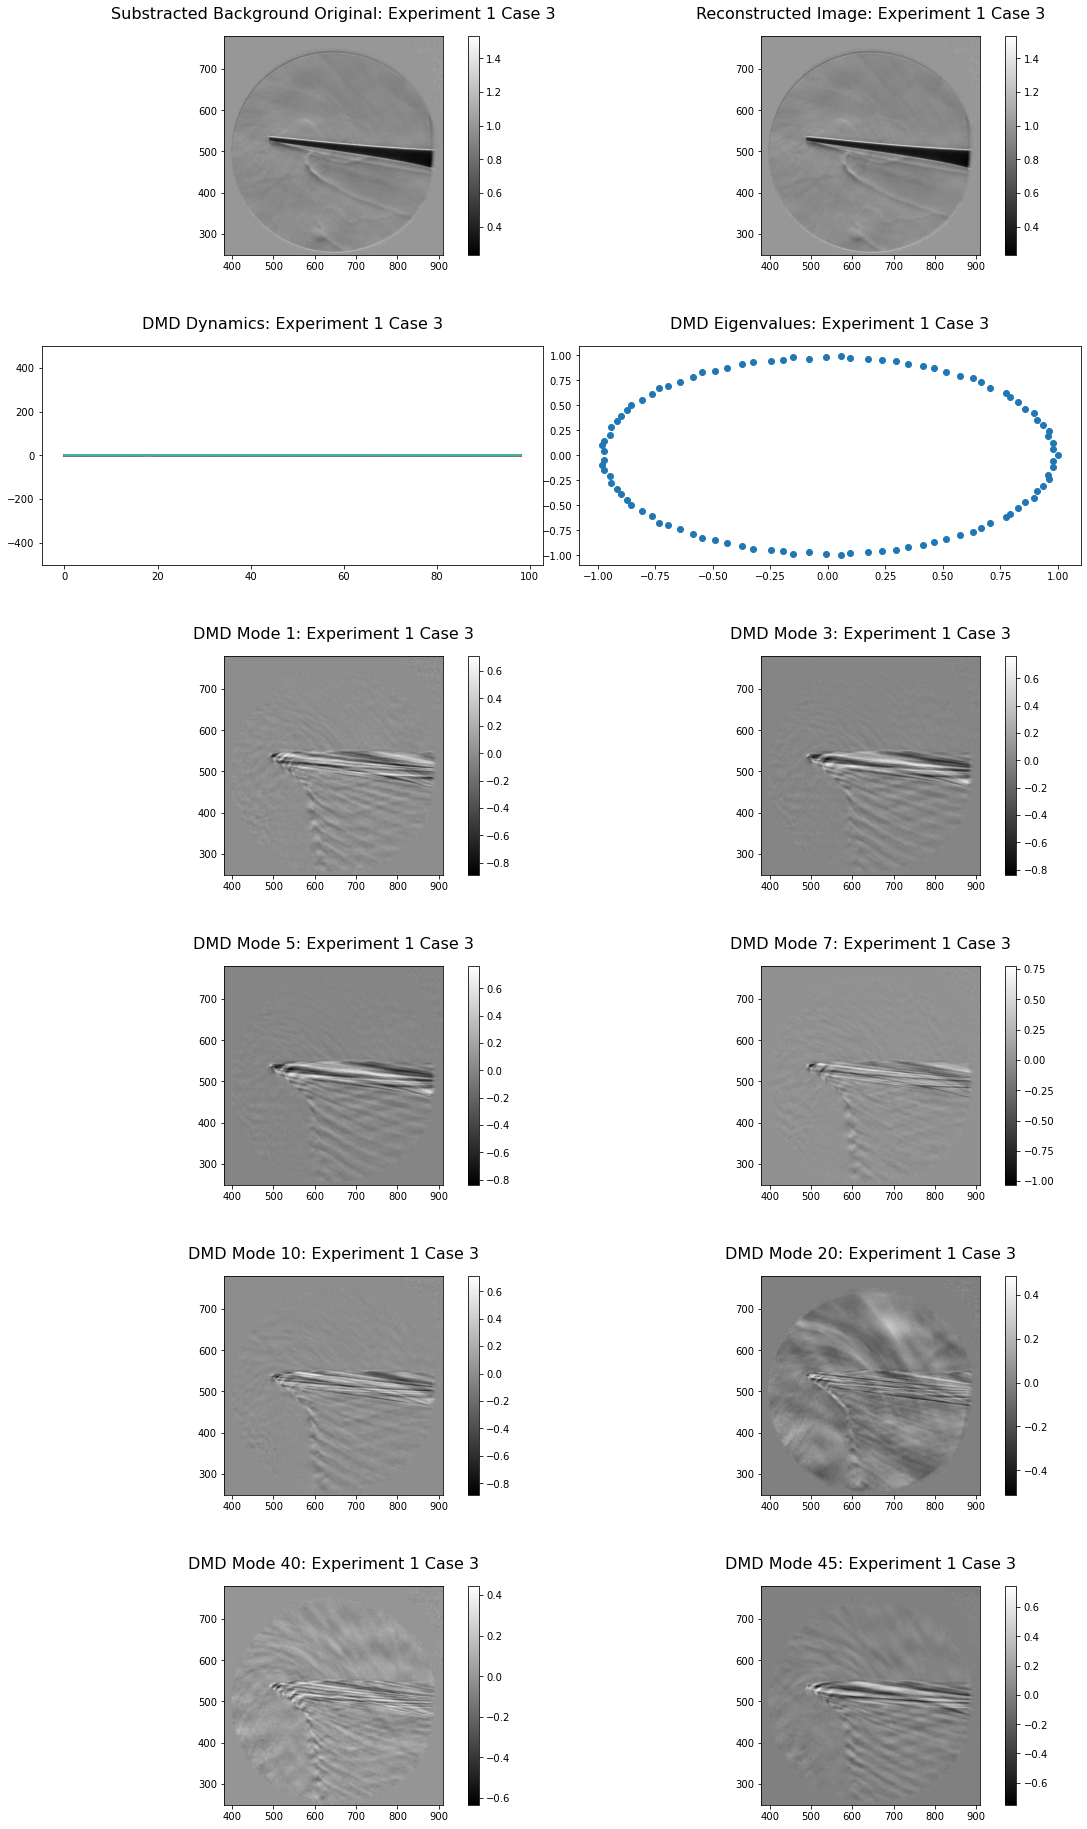

<font size = "5"><center>Experiment 1 Case 4</center></font>

----------------------------------------------------------------------------------------------------------------

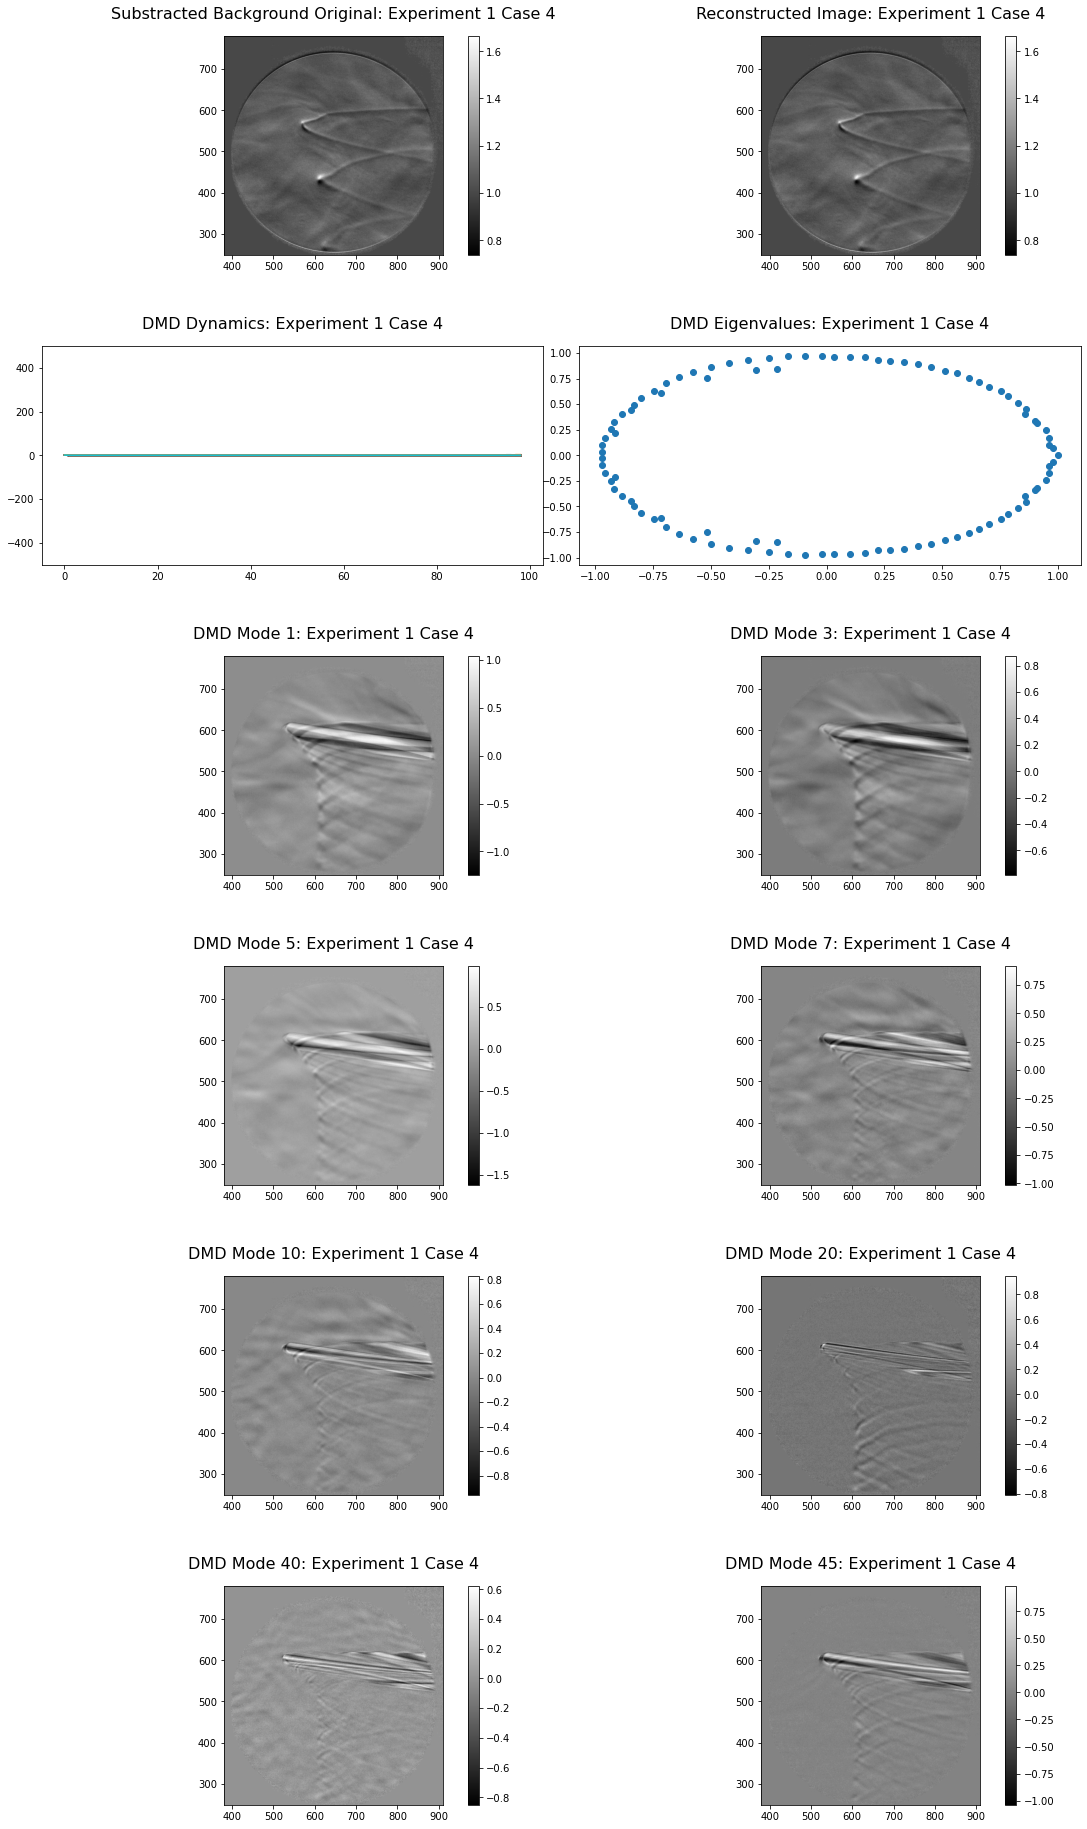

<font size = "5"><center>Experiment 1 Case 5</center></font>

----------------------------------------------------------------------------------------------------------------

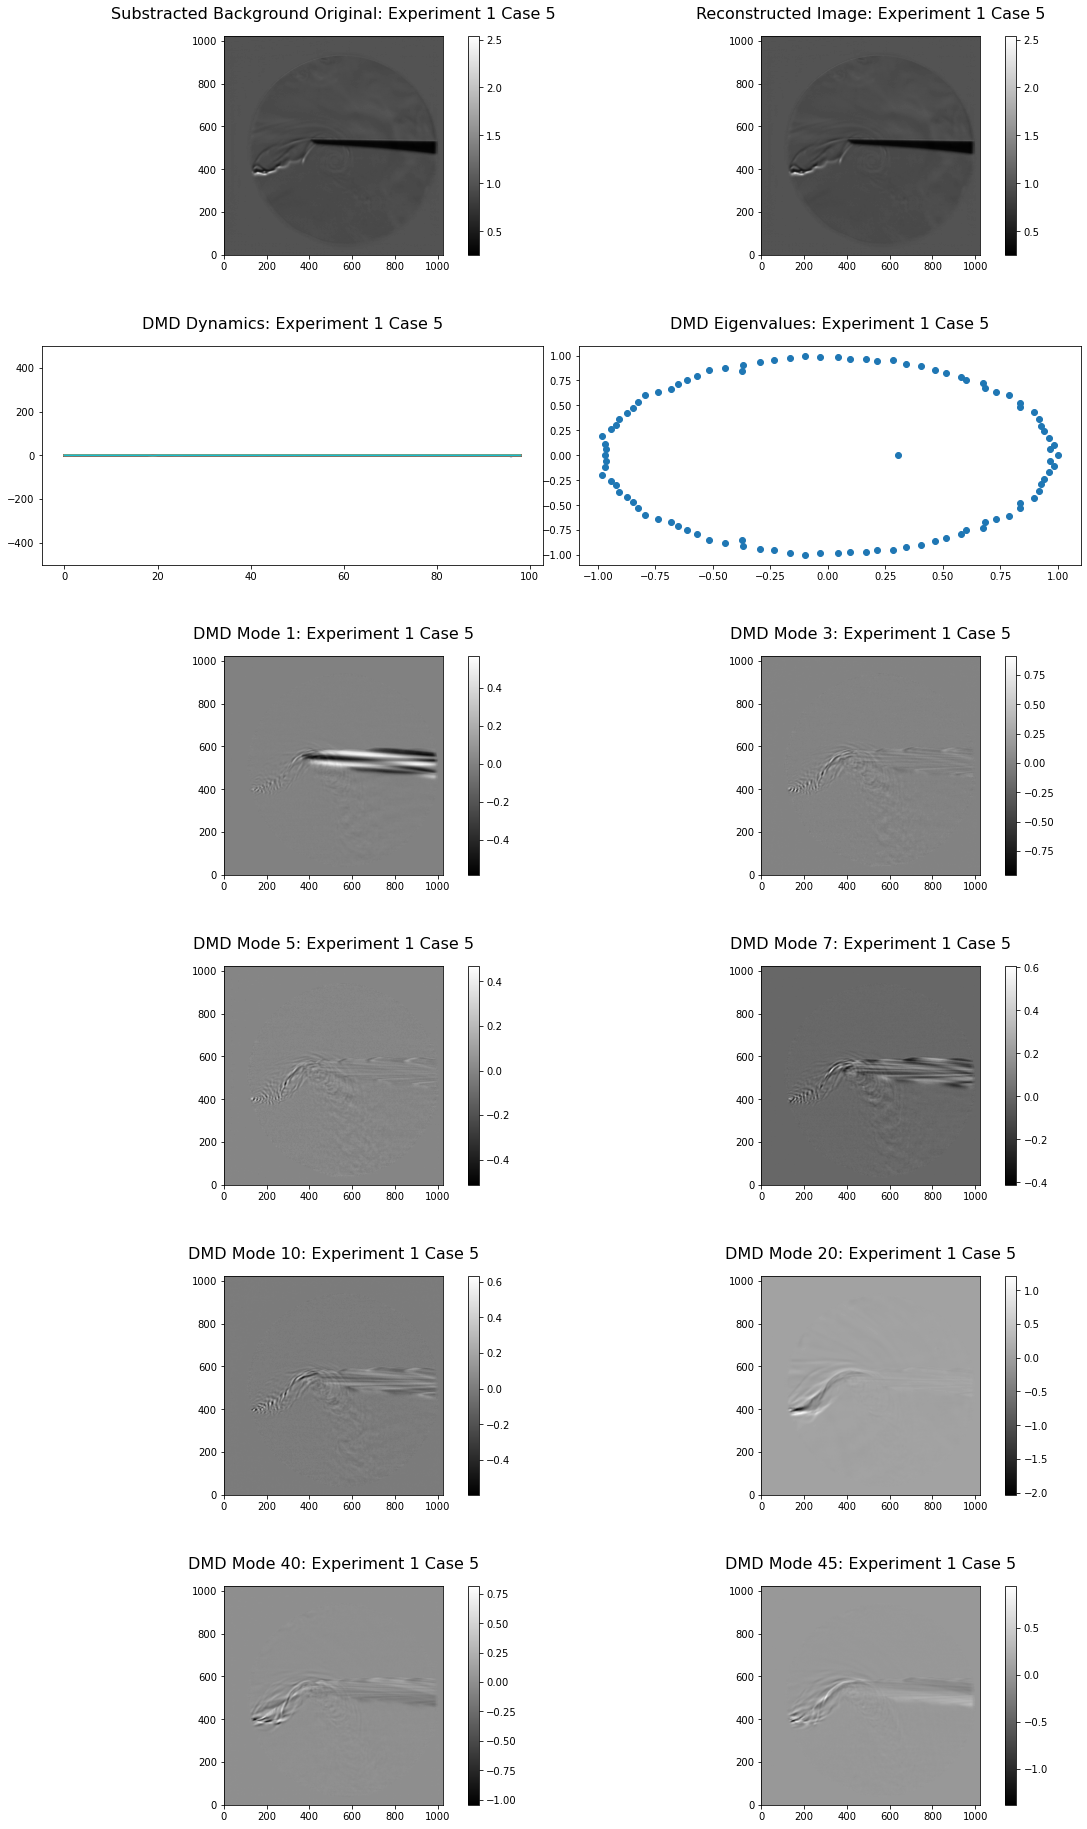

<font size = "5"><center>Experiment 1 Case 6</center></font>

----------------------------------------------------------------------------------------------------------------

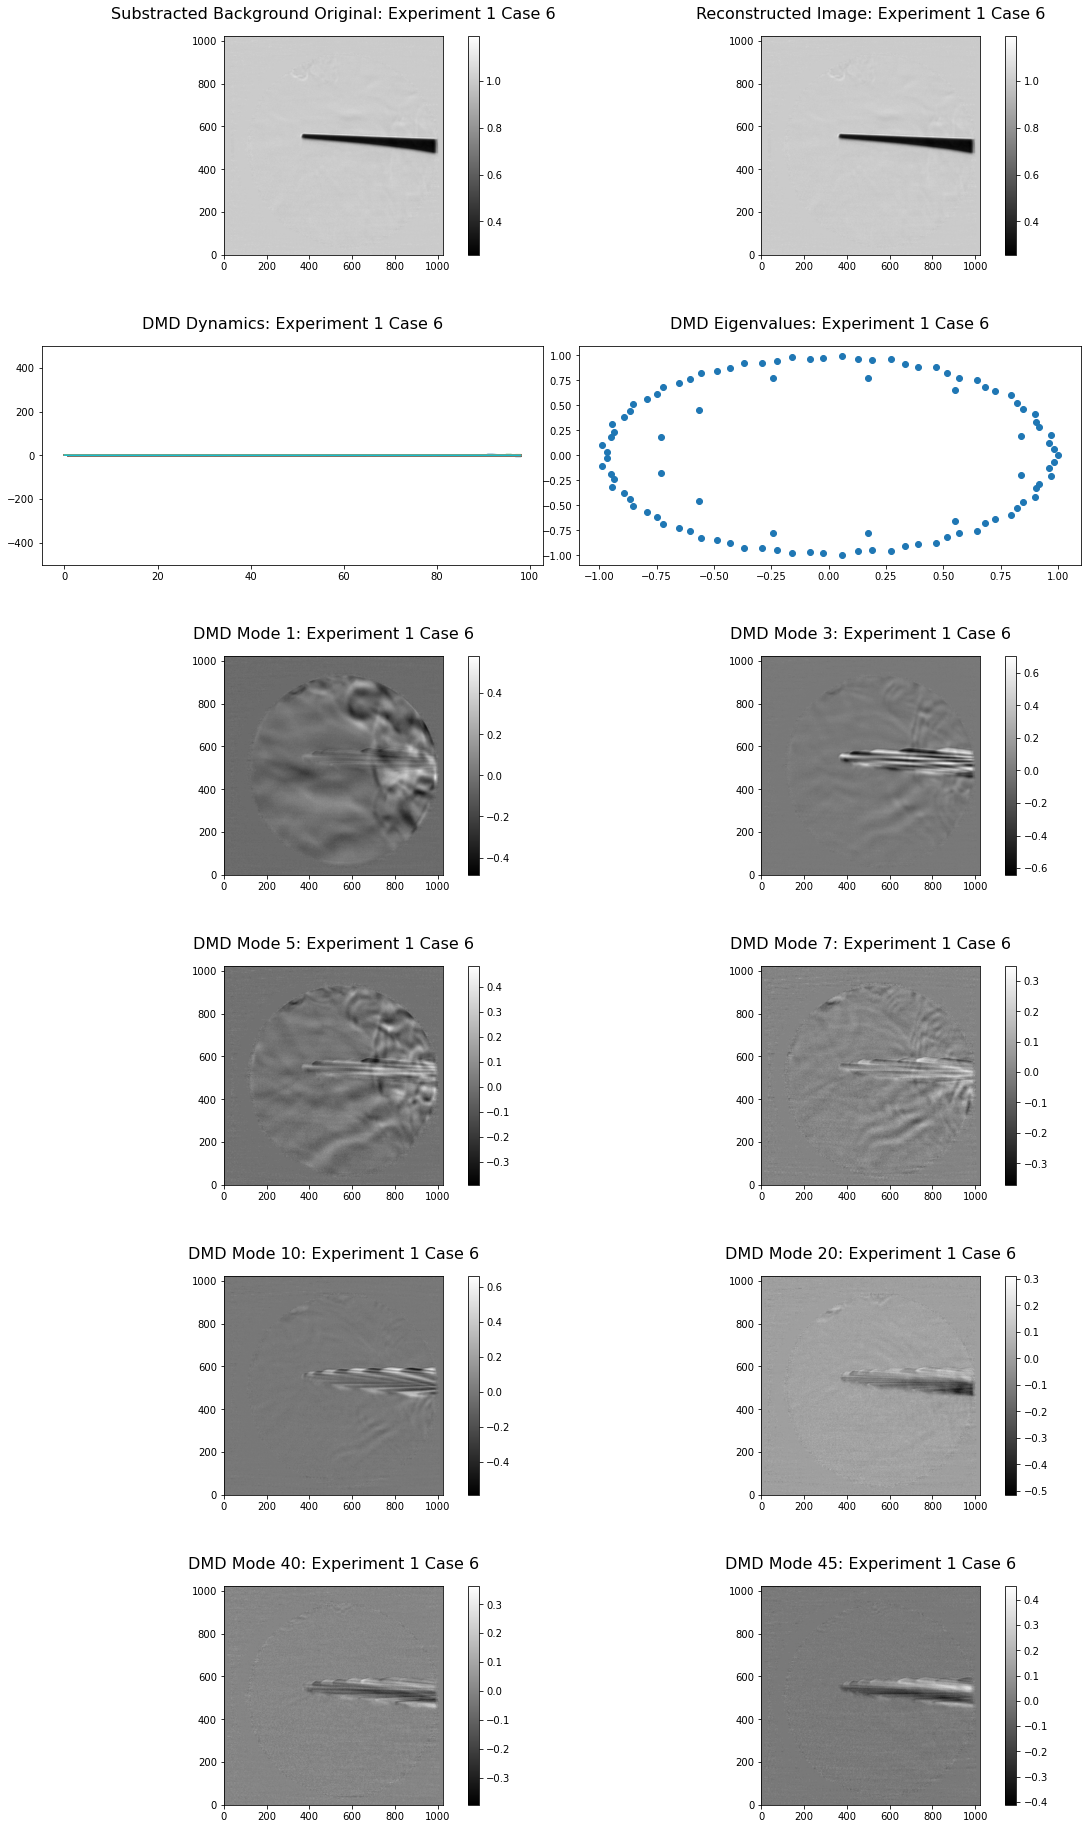

<font size = "5"><center>Experiment 1 Case 7</center></font>

----------------------------------------------------------------------------------------------------------------

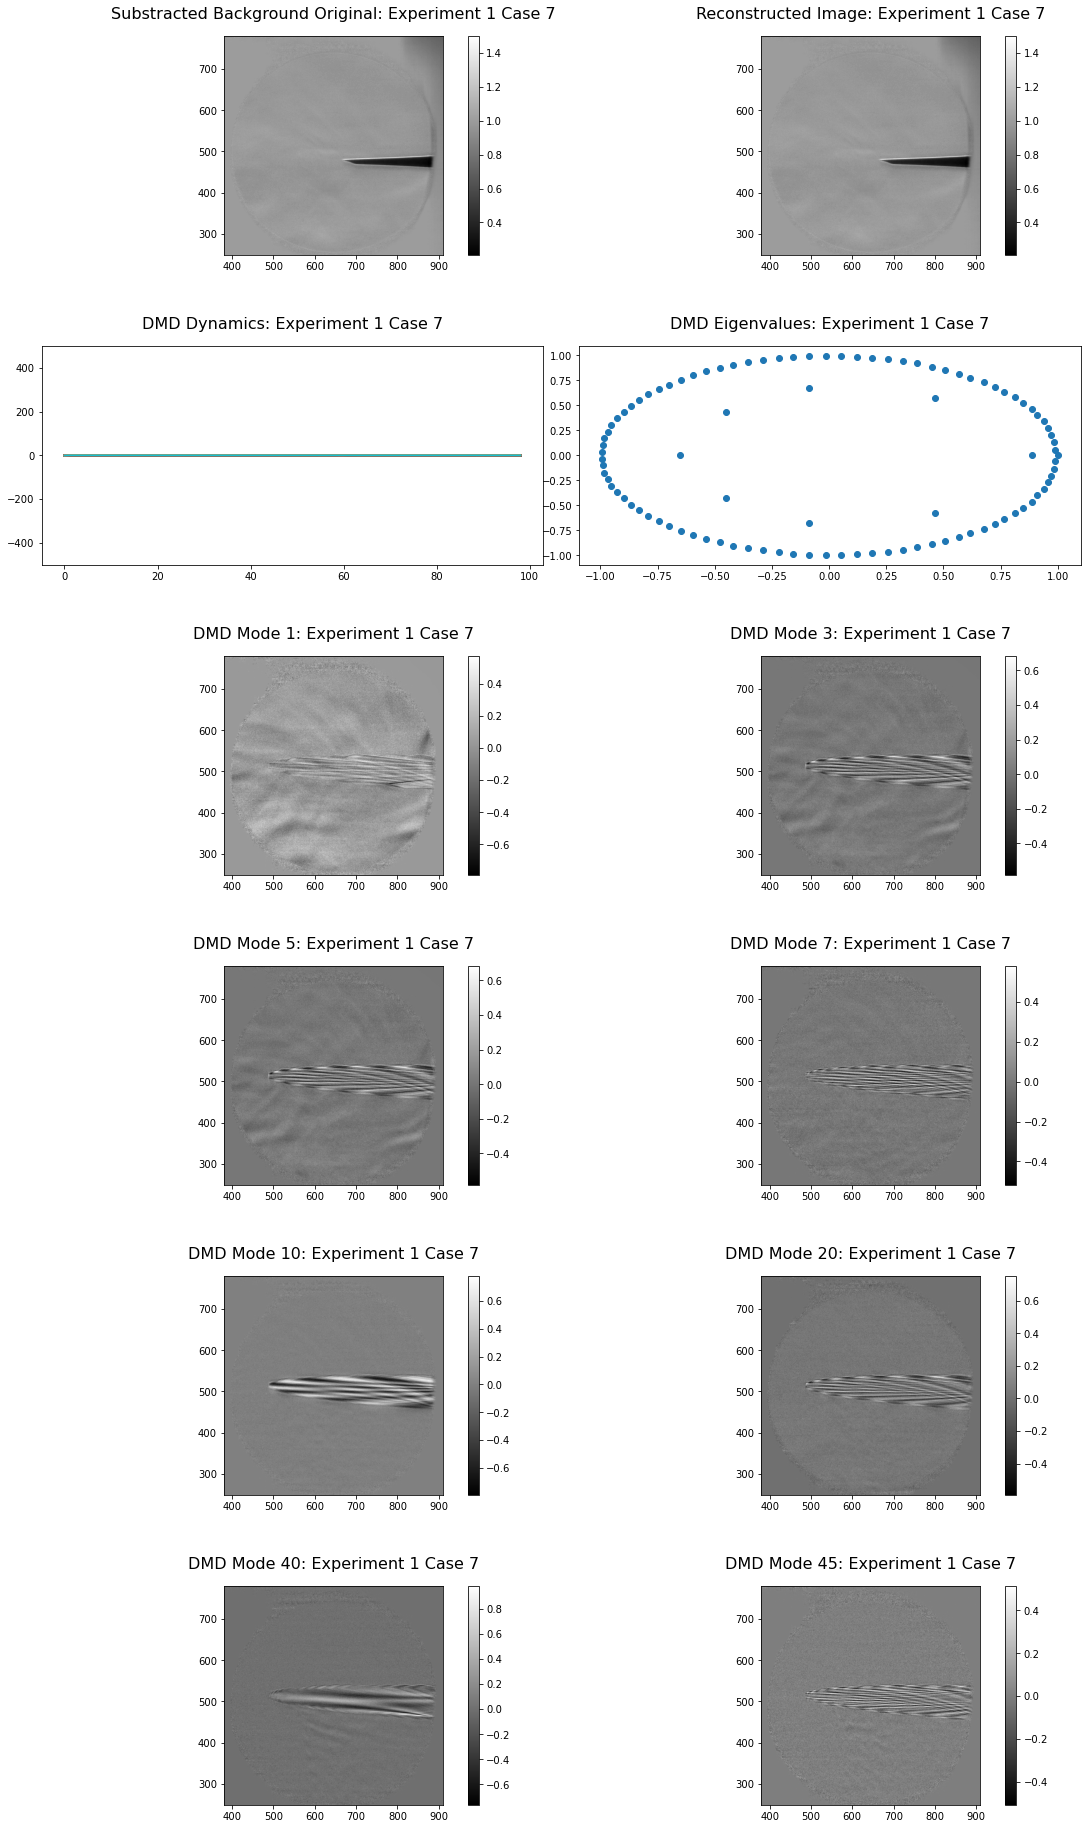

<font size = "5"><center>Experiment 1 Case 8</center></font>

----------------------------------------------------------------------------------------------------------------

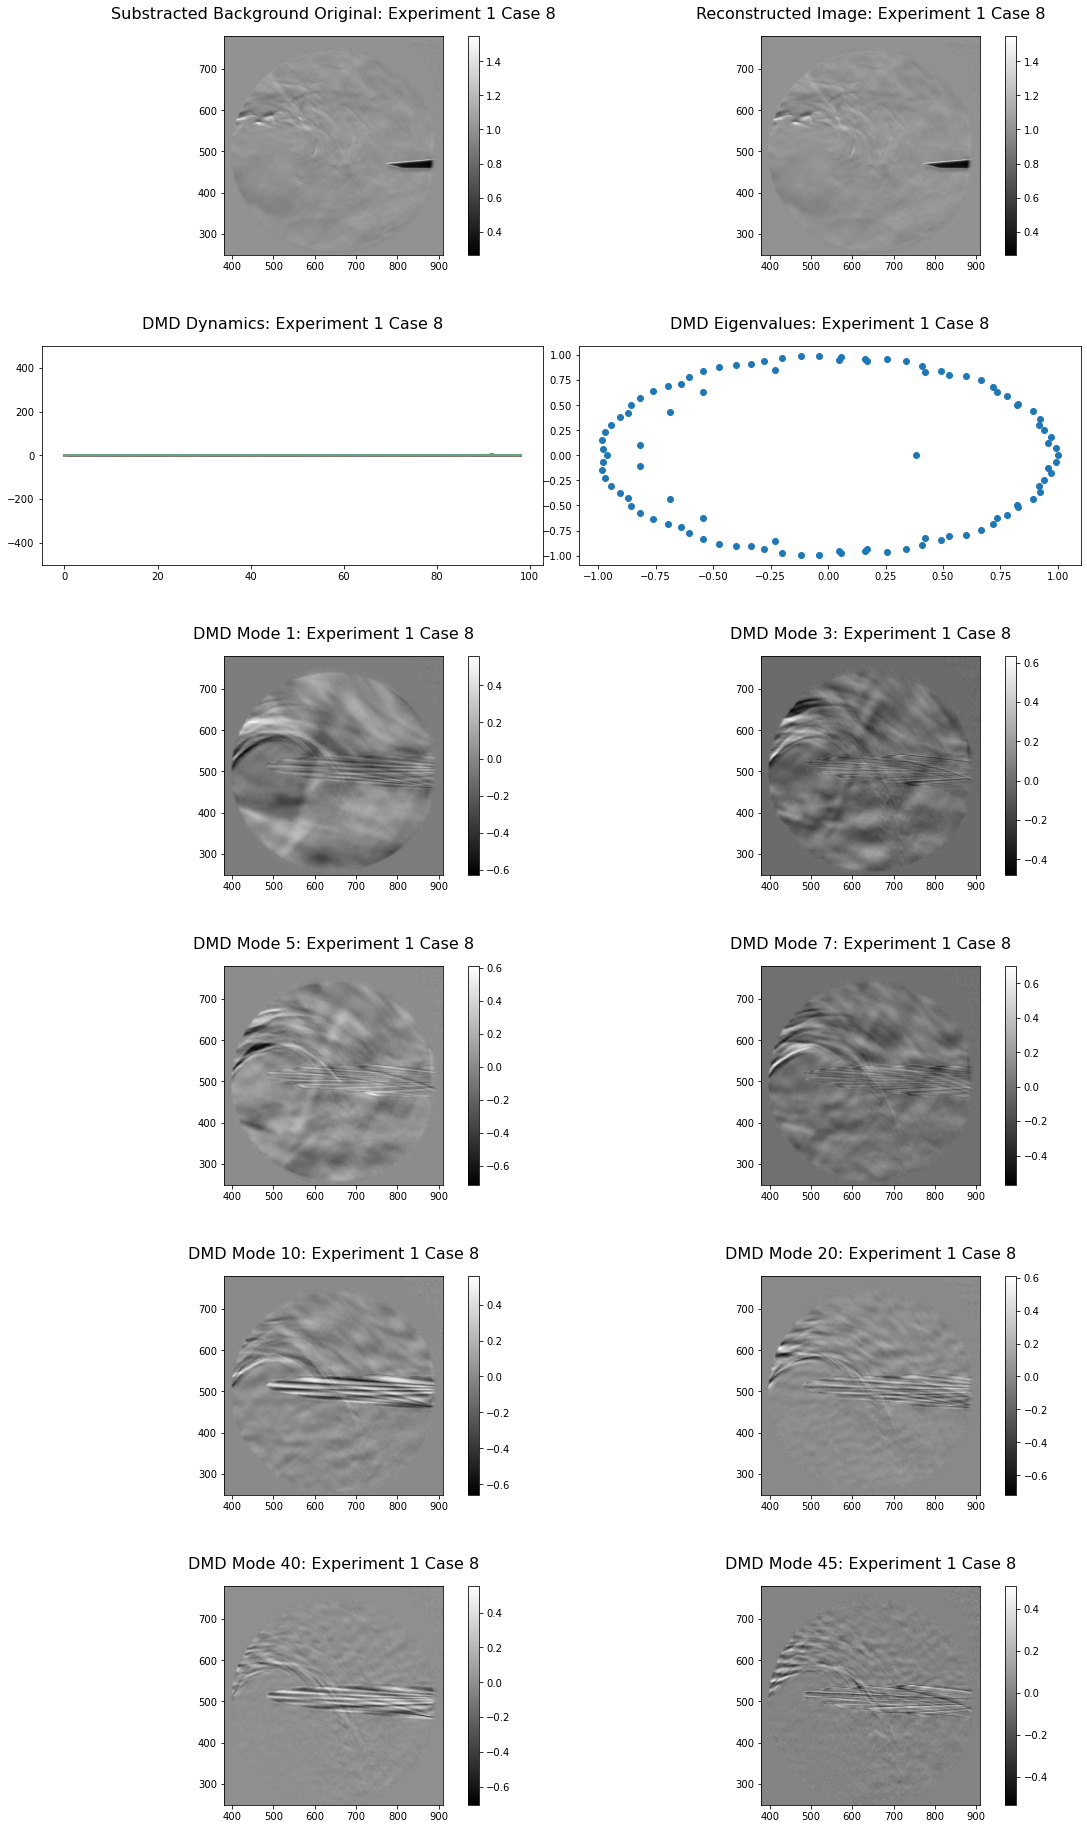

<font size = "5"><center>Experiment 1 Case 9</center></font>

----------------------------------------------------------------------------------------------------------------

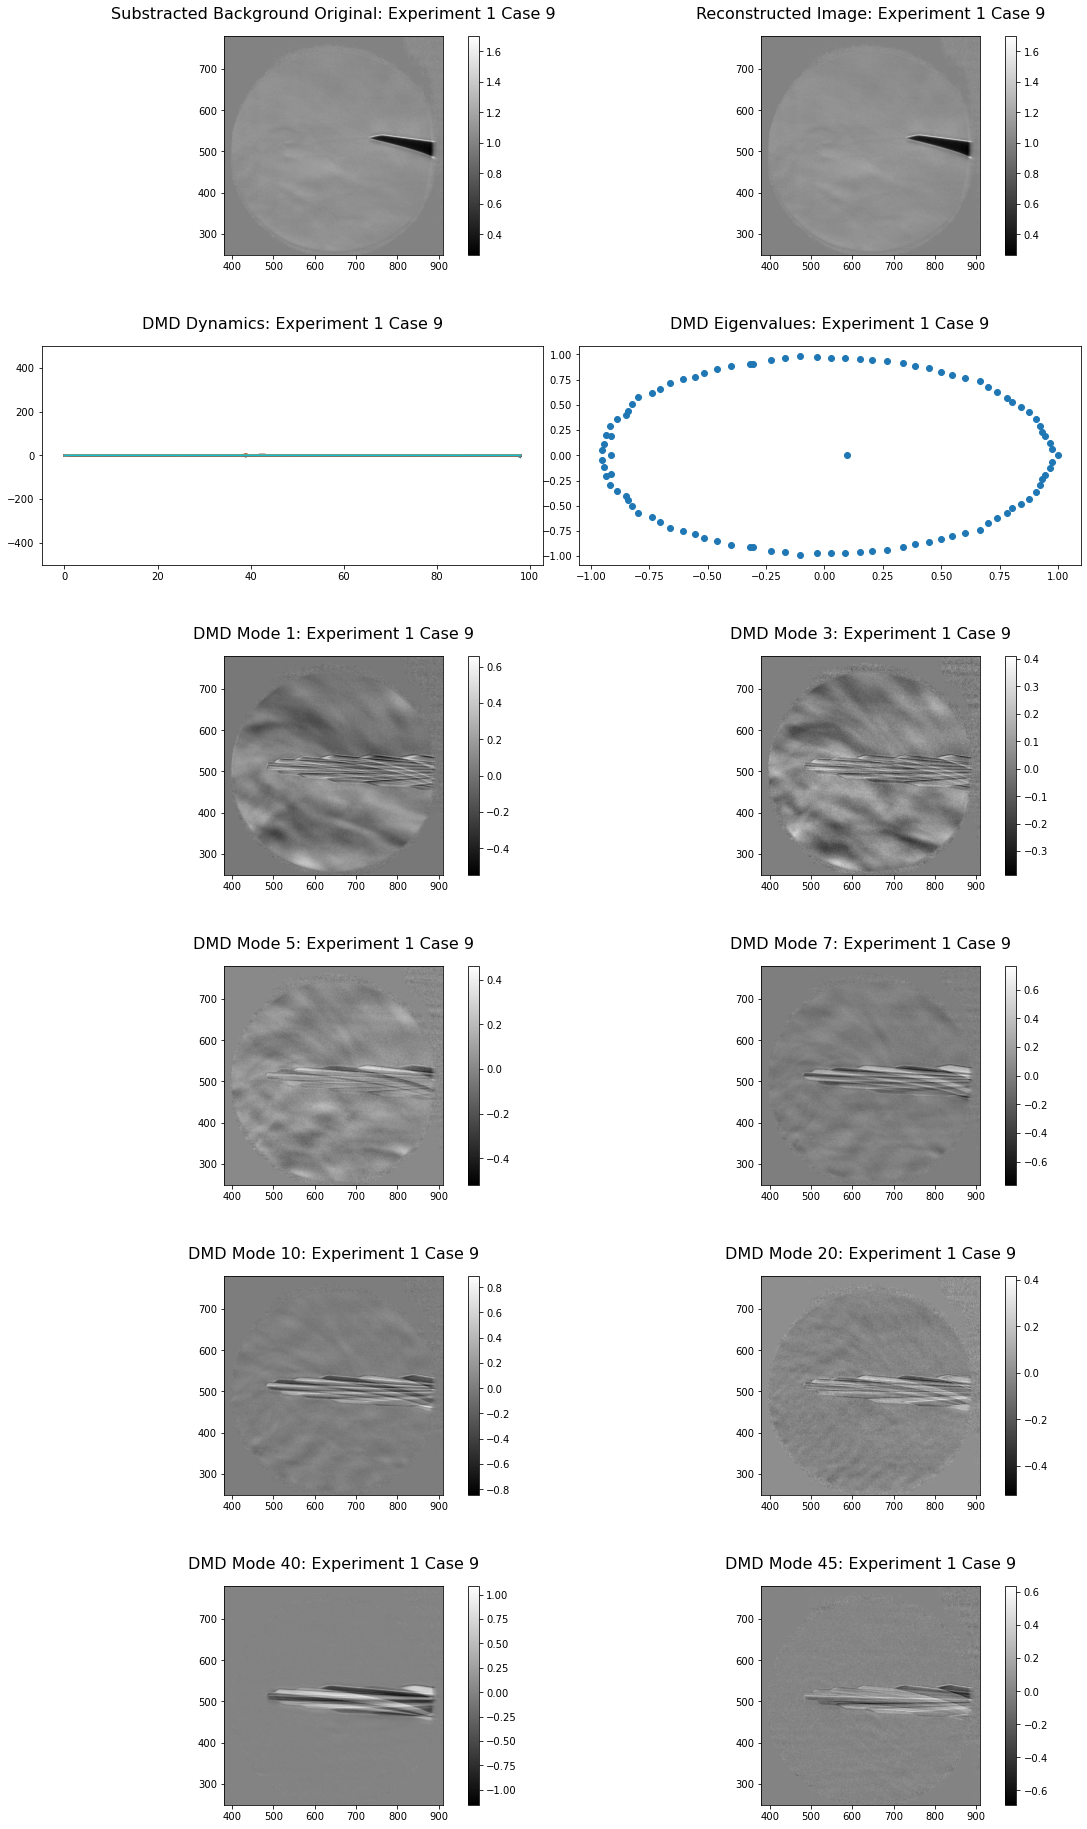

<font size = "5"><center>Experiment 2 Case 1</center></font>

----------------------------------------------------------------------------------------------------------------

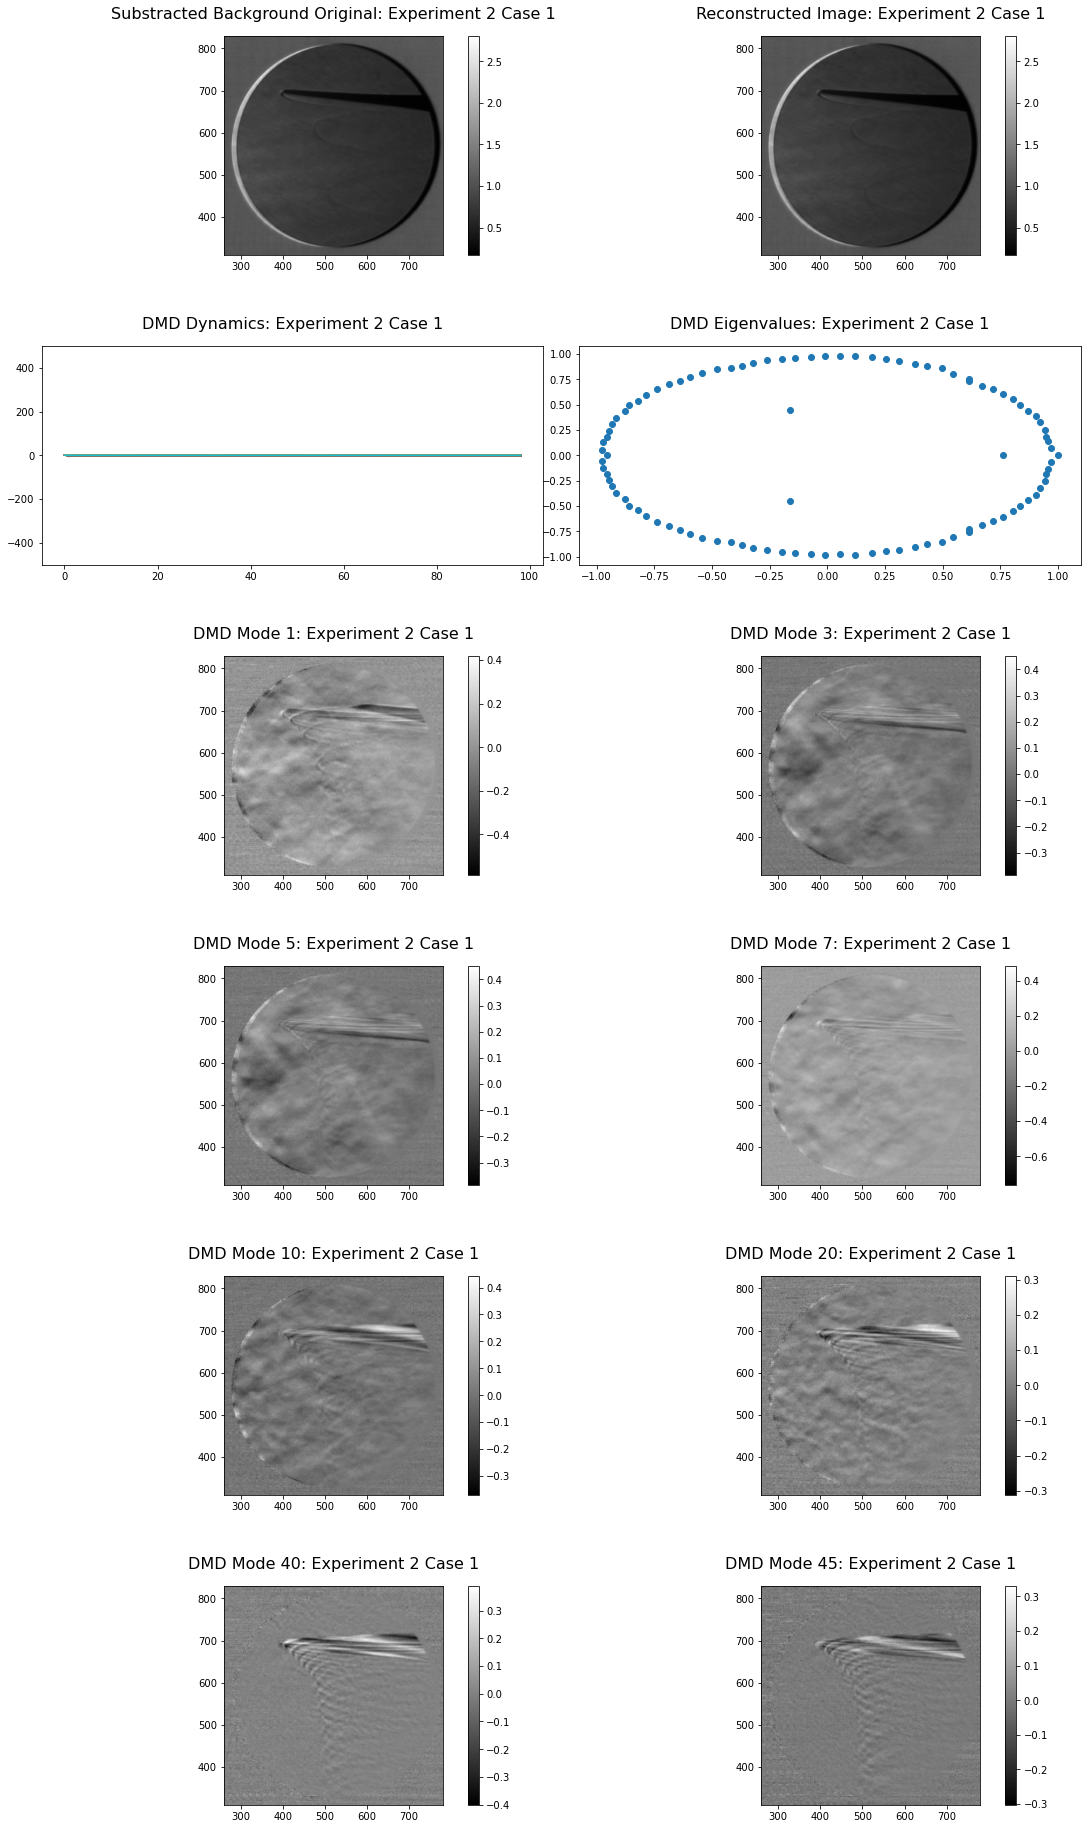

<font size = "5"><center>Experiment 2 Case 2</center></font>

----------------------------------------------------------------------------------------------------------------

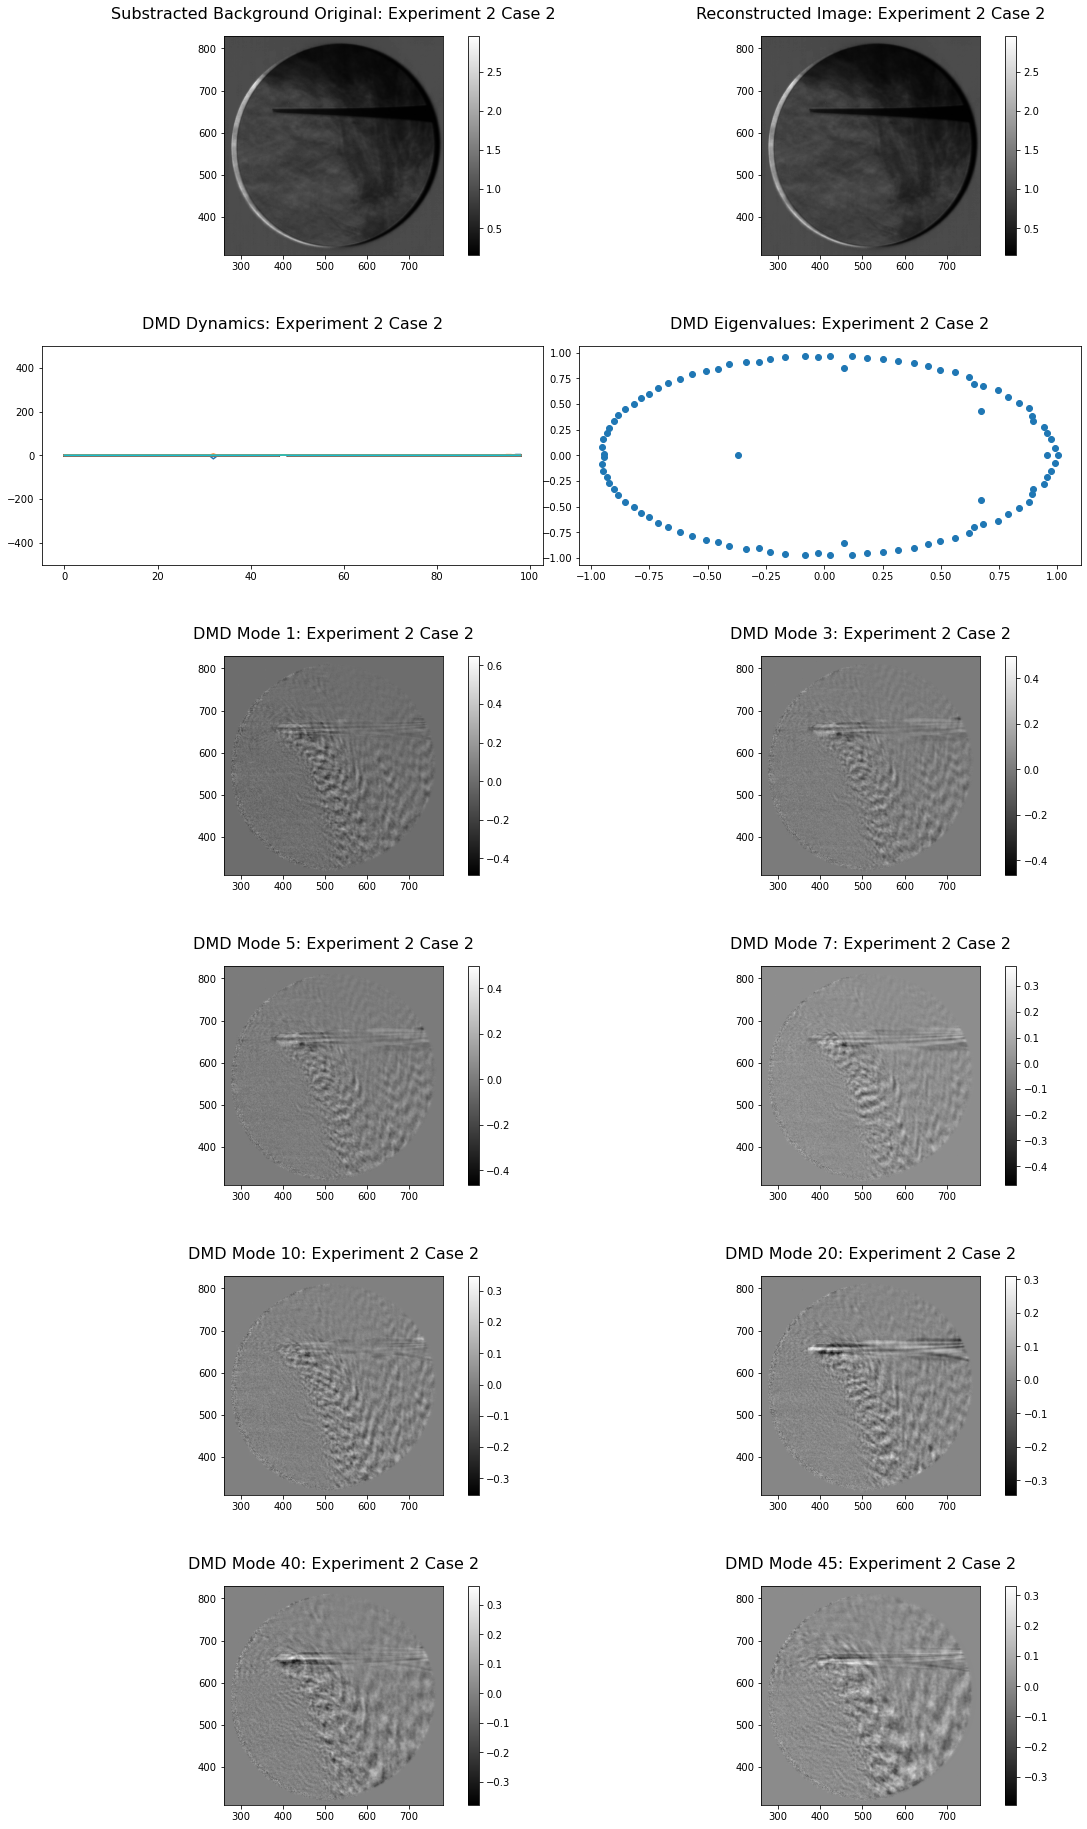

<font size = "5"><center>Experiment 3 Case 1</center></font>

----------------------------------------------------------------------------------------------------------------

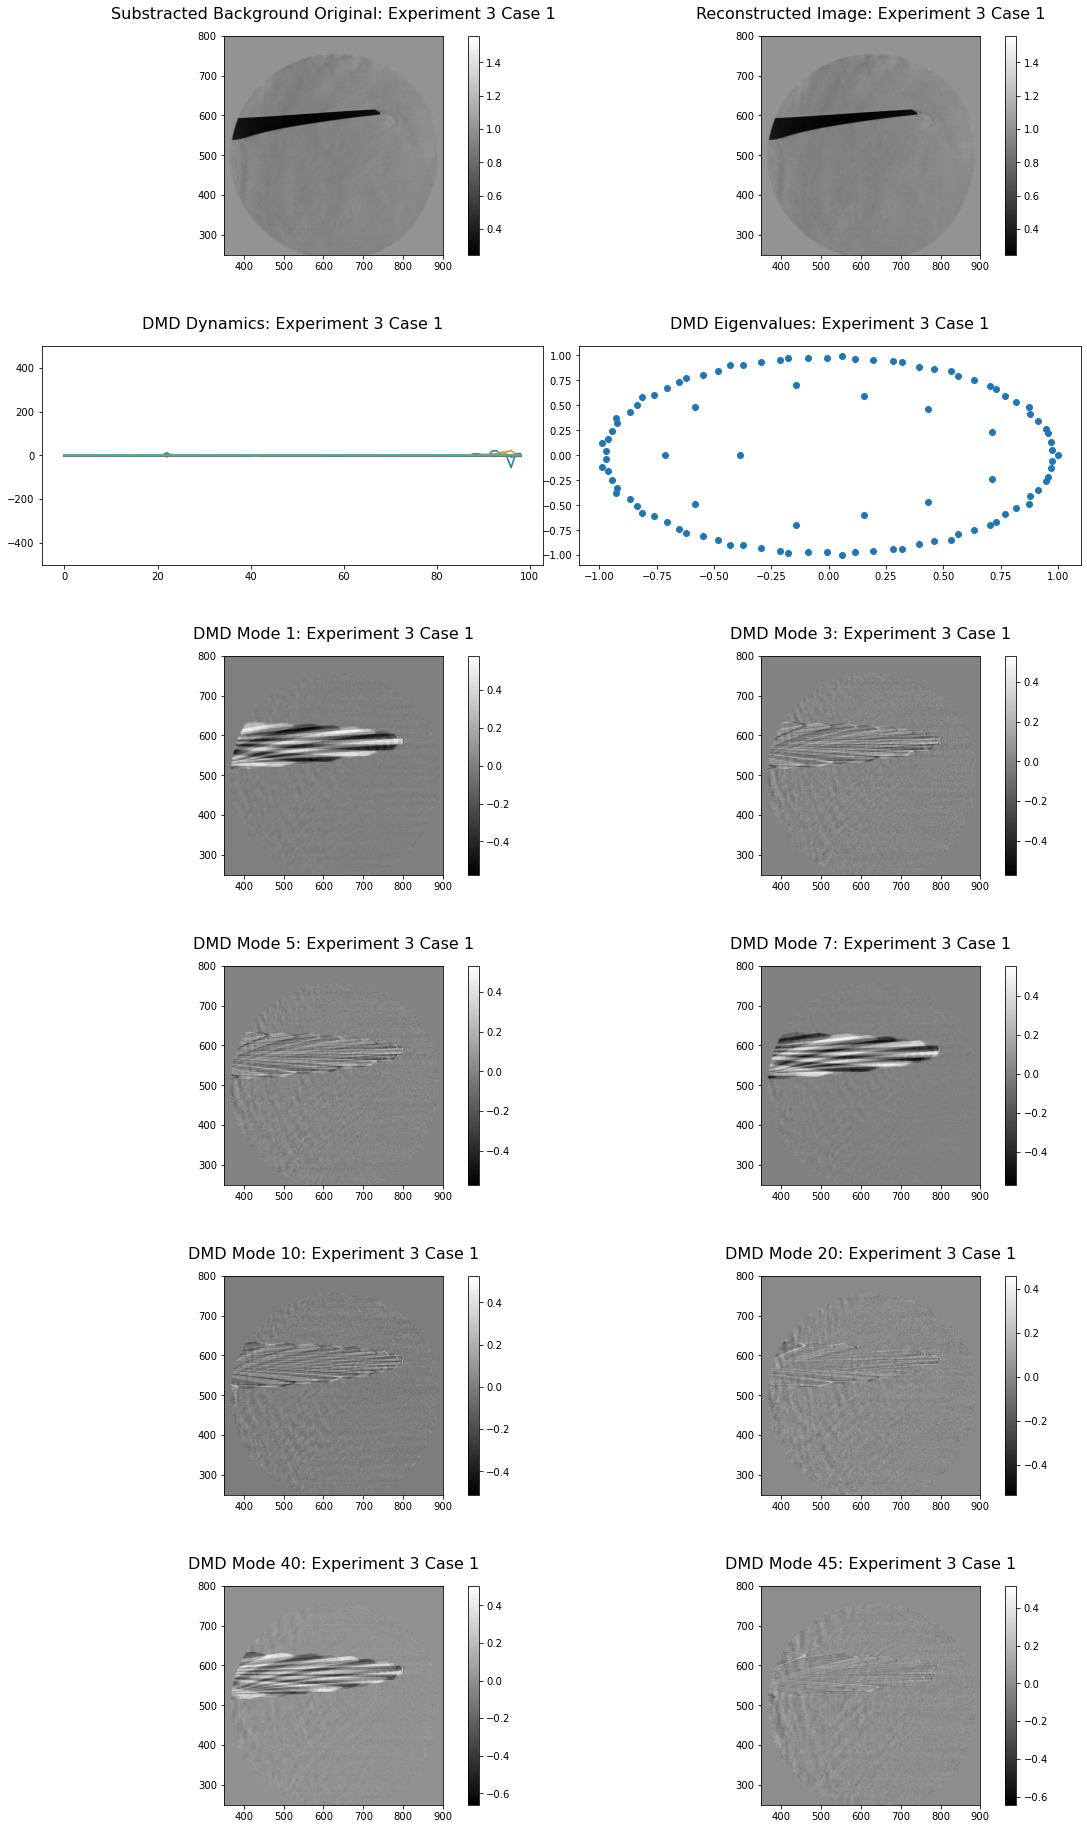

<font size = "5"><center>Experiment 3 Case 2</center></font>

----------------------------------------------------------------------------------------------------------------

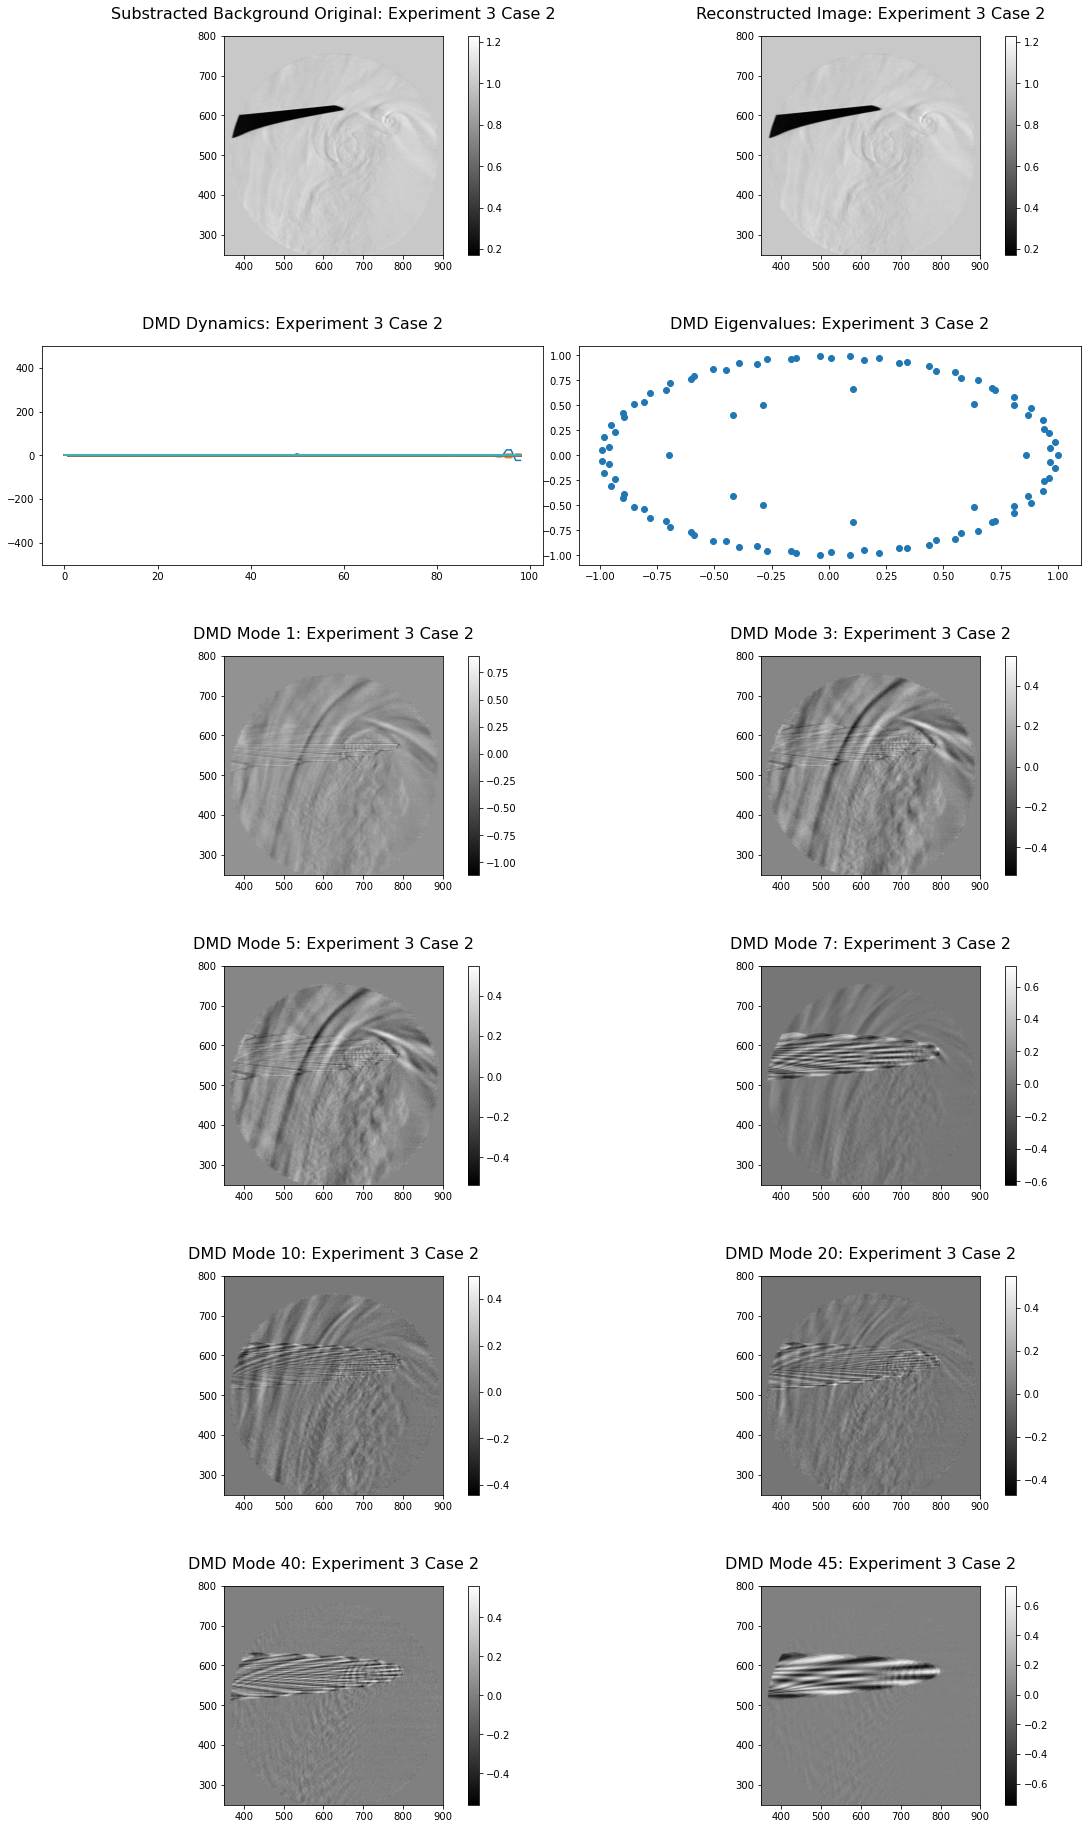

<font size = "5"><center>Experiment 3 Case 3</center></font>

----------------------------------------------------------------------------------------------------------------

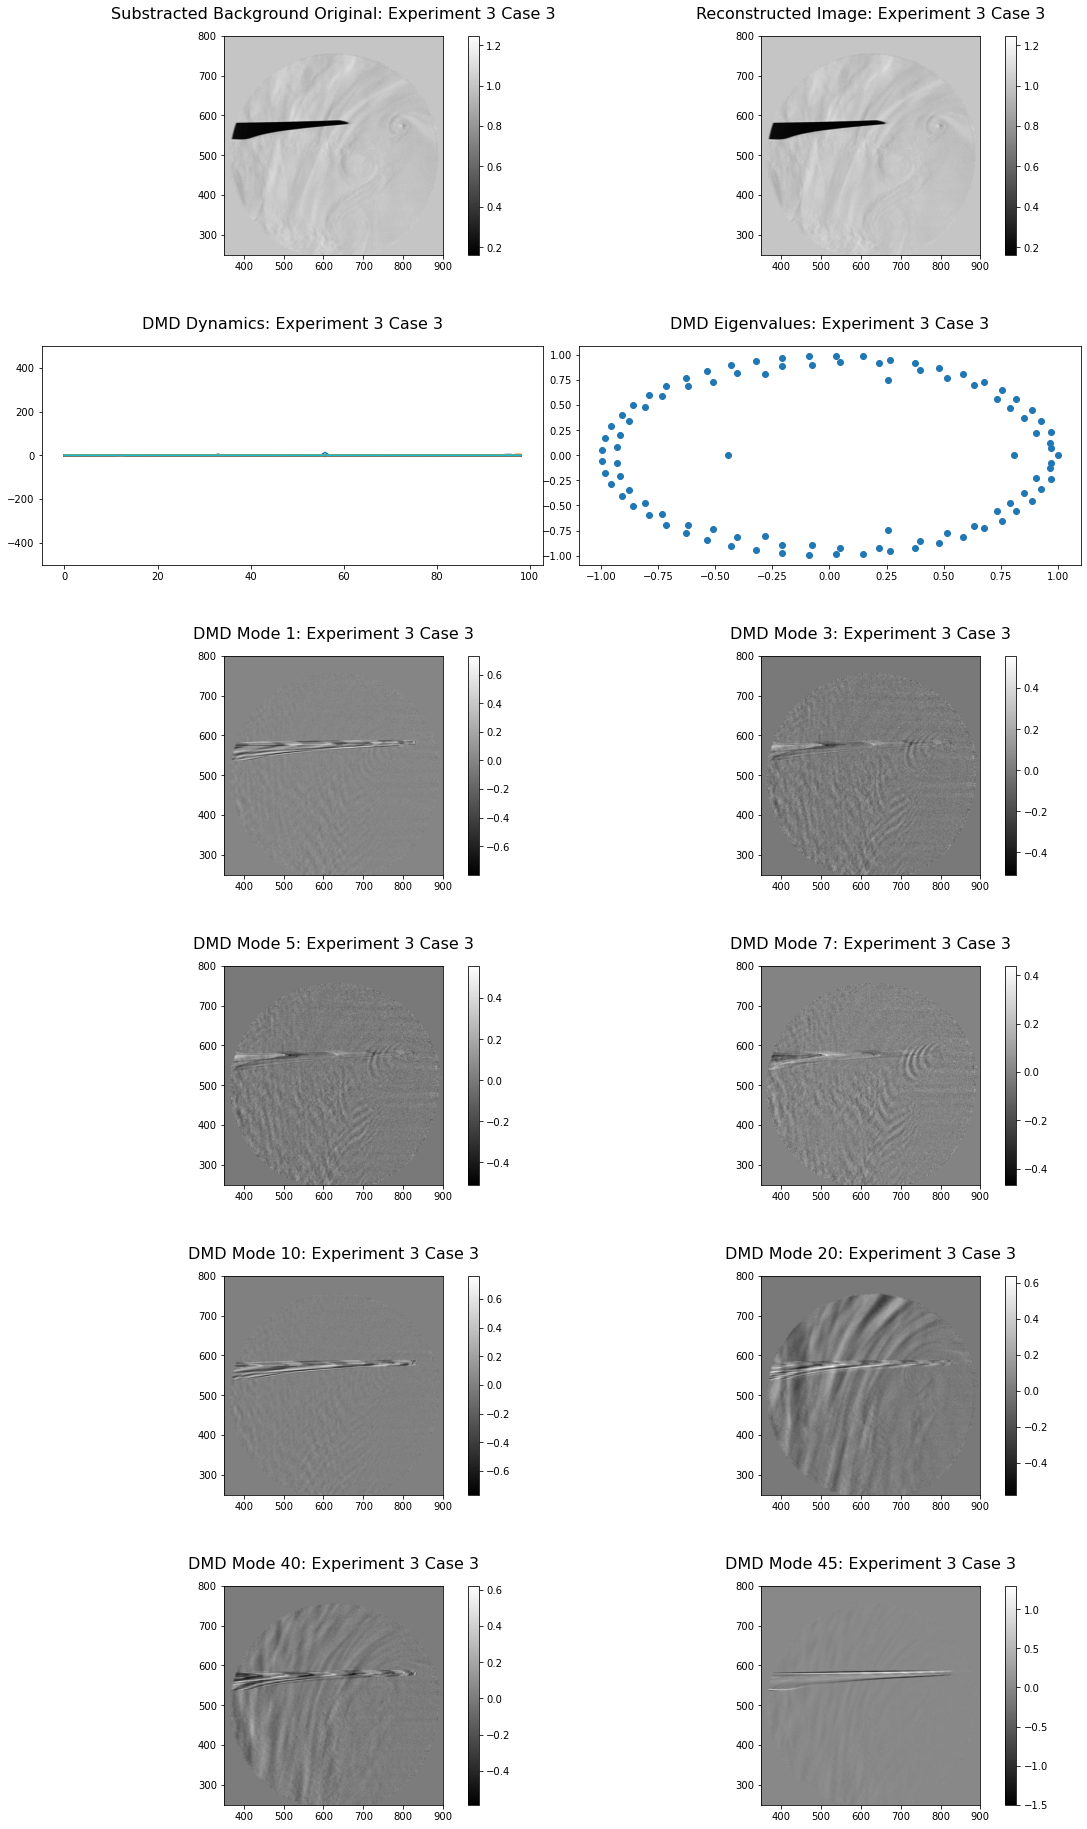

<font size = "5"><center>Experiment 3 Case 4</center></font>

----------------------------------------------------------------------------------------------------------------

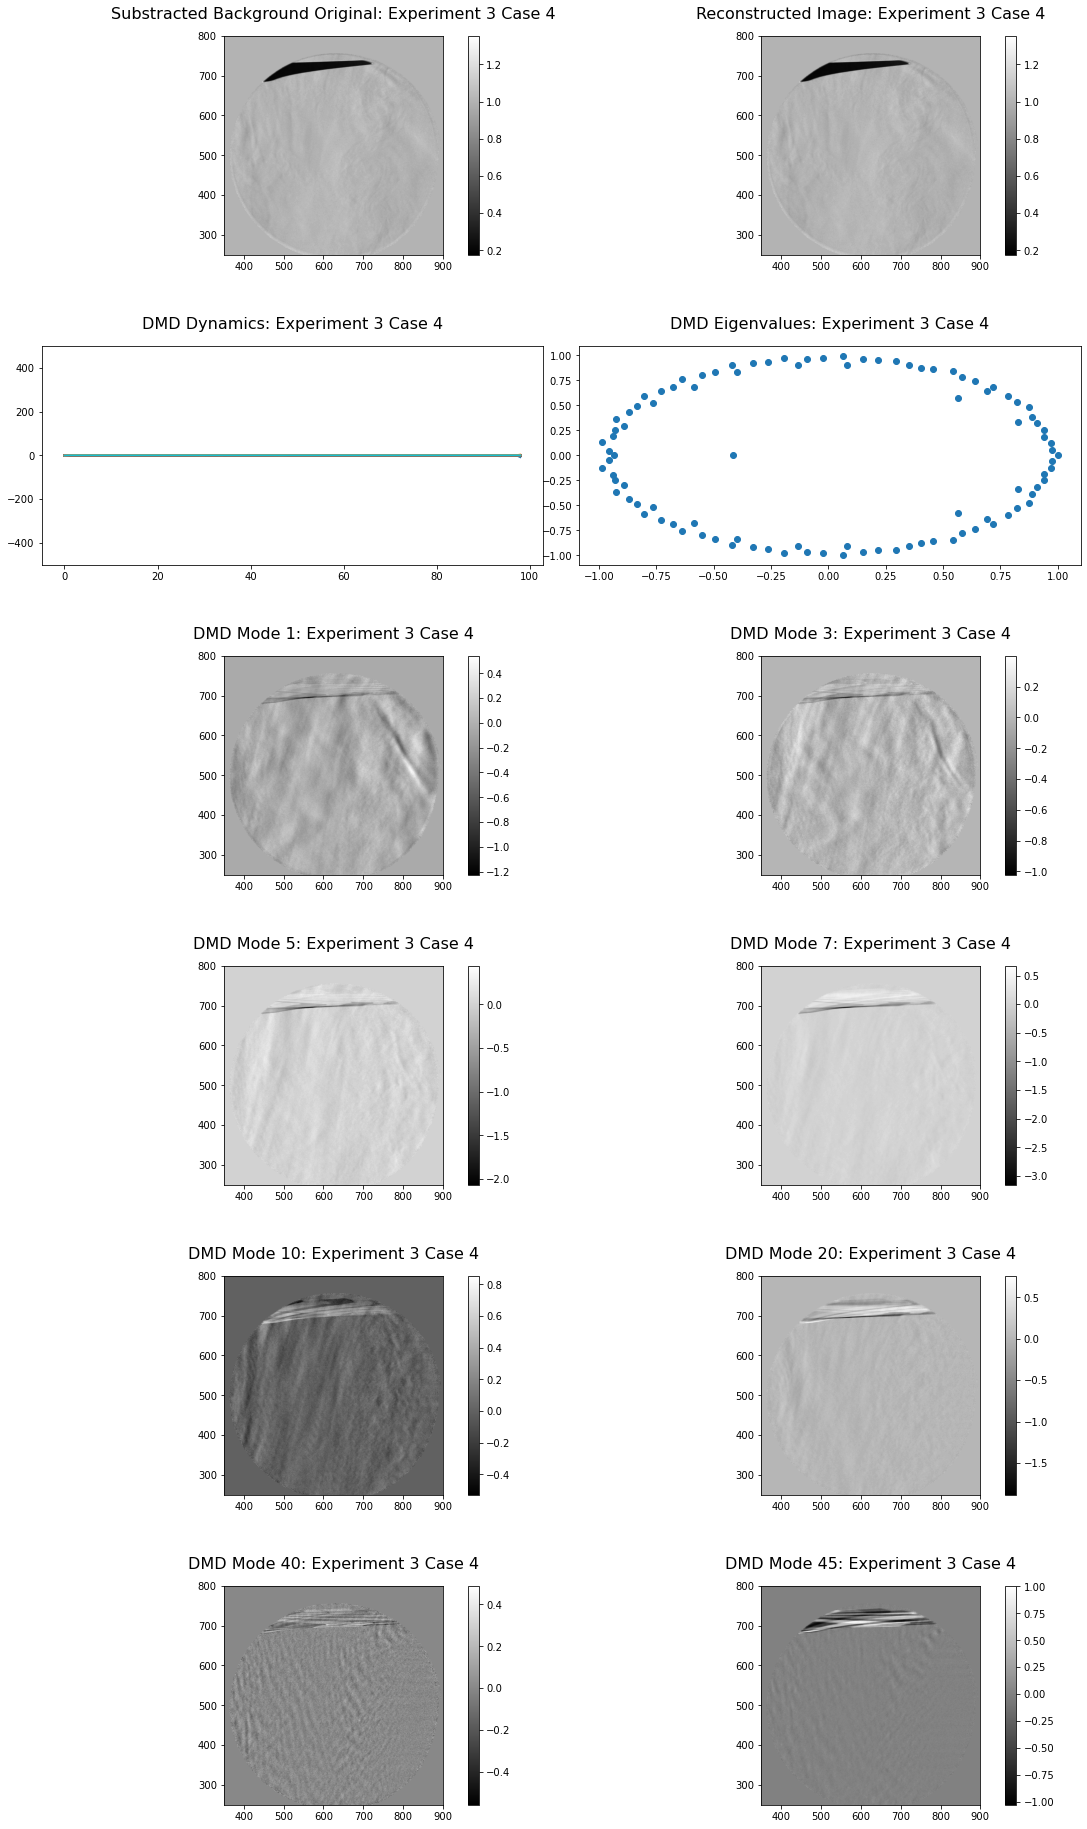

<font size = "5"><center>Experiment 3 Case 5</center></font>

----------------------------------------------------------------------------------------------------------------

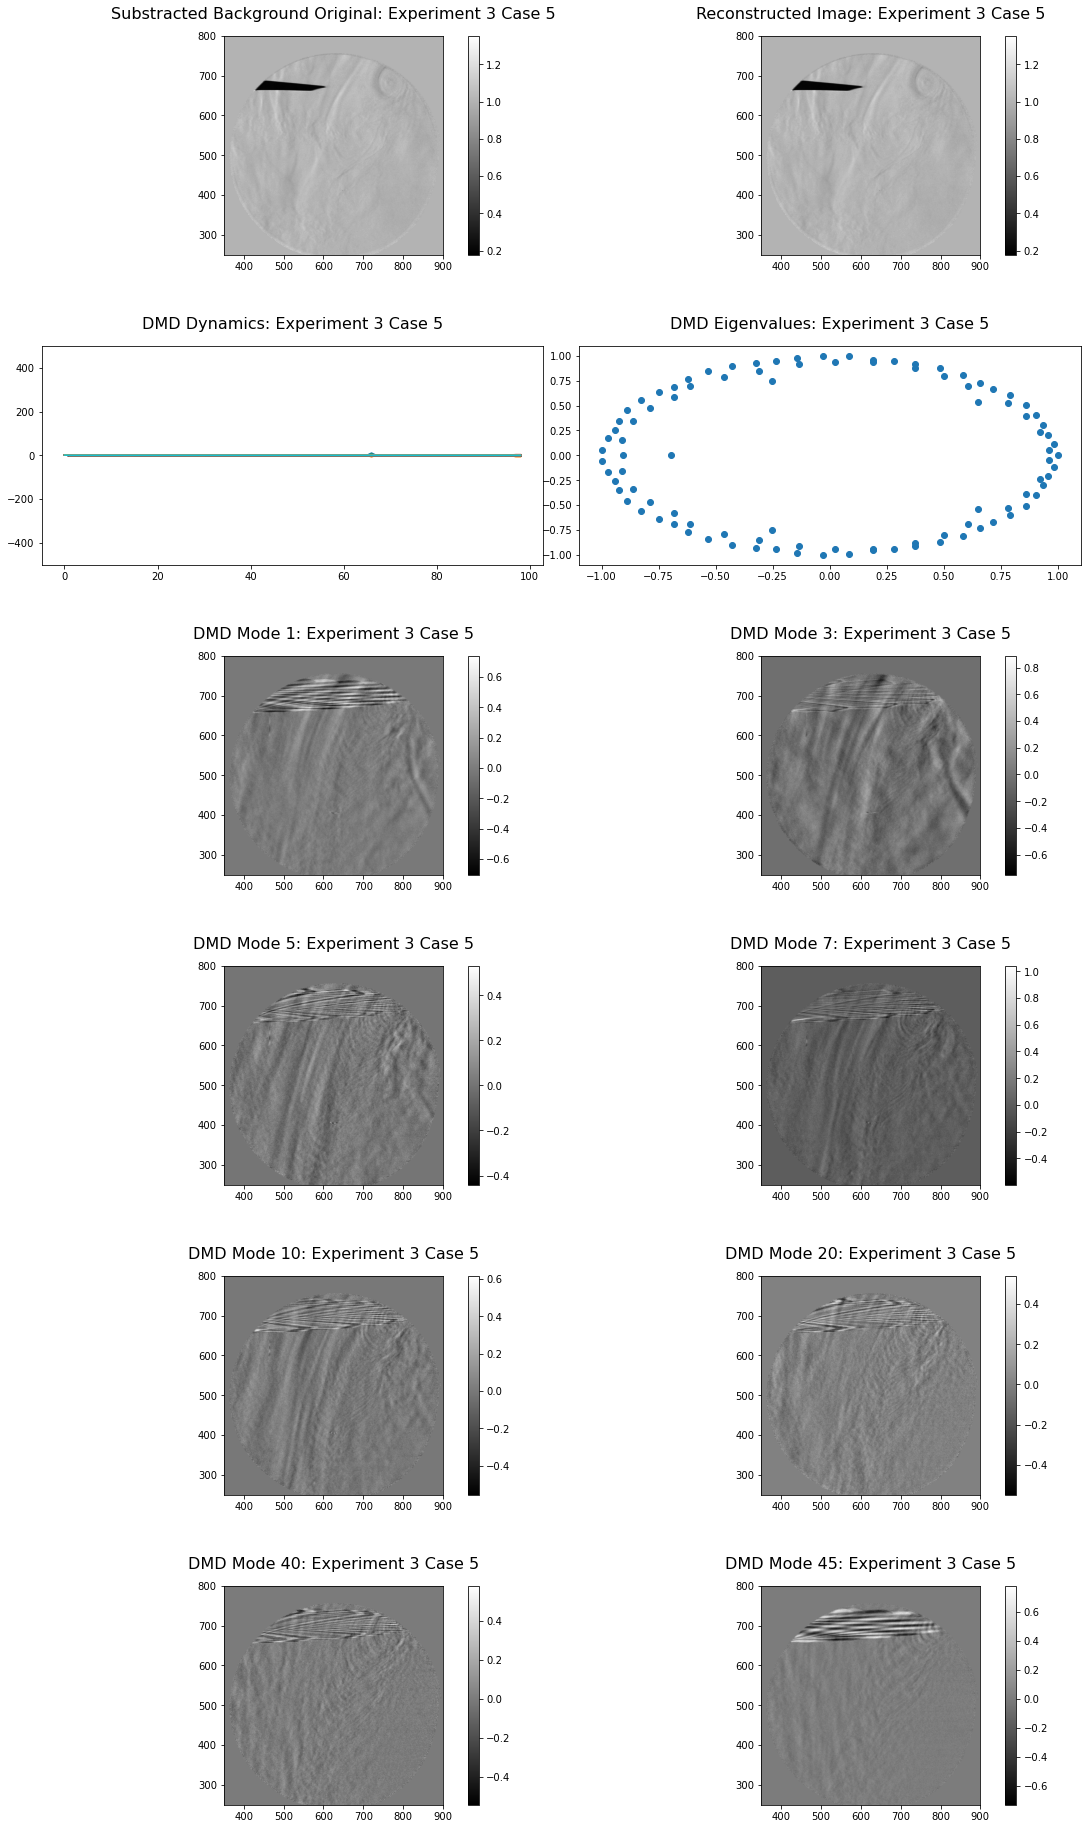

In [30]:
start_data_process()
plot_results()